In [66]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import acf, pacf, adfuller
import scipy.stats as stats
import seaborn as sns
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA
from scipy.optimize import curve_fit
from numba import jit, njit

# **1. Przygotowanie danych do analizy**

In [67]:
df = pd.read_csv("AMZN.csv")
# df

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       252 non-null    object 
 1   Open       252 non-null    float64
 2   High       252 non-null    float64
 3   Low        252 non-null    float64
 4   Close      252 non-null    float64
 5   Adj Close  252 non-null    float64
 6   Volume     252 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 13.9+ KB


In [69]:
date = df["Date"].values
Date = pd.to_datetime(date)
print(len(Date.values)) # poczatkowo mielismy dane tylko dla 252 dni

Open = df["Open"].values
High = df["High"].values
Low = df["Low"].values
Close = df["Close"].values
Adj_Close = df["Adj Close"].values
Volume = df["Volume"].values

252


* # **zbadanie jakości danych (detekcja wartości spoza zakładanego przedziału, identyfikacja ewentualnych braków w danych lub błędów w próbkowaniu)**

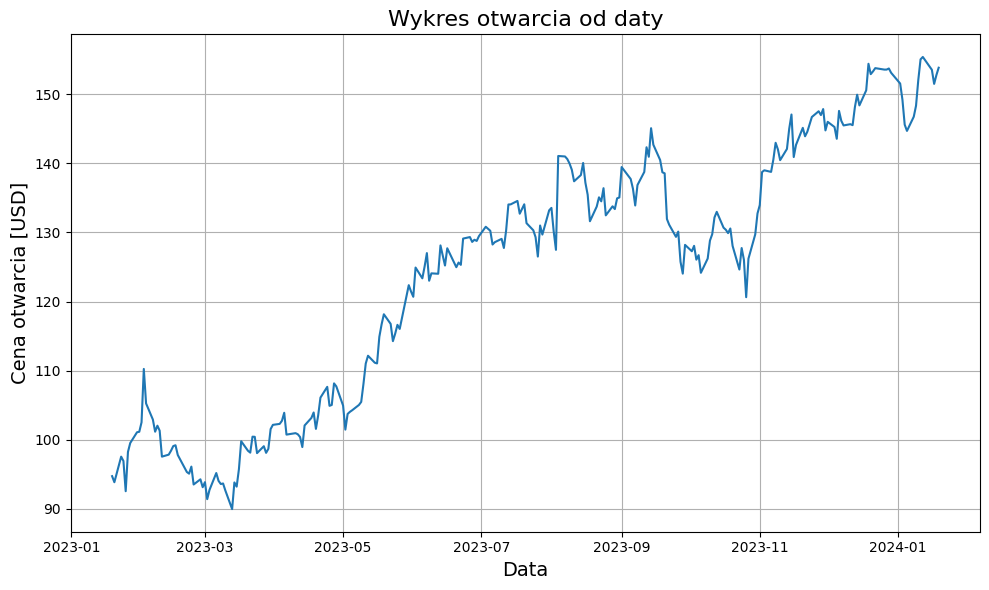

In [70]:
# Zwykła wizualizacja danych zmiennych w czasie
plt.figure(figsize=(10, 6))
plt.plot(Date, Open)
plt.title("Wykres otwarcia od daty", fontsize=16)  
plt.xlabel("Data", fontsize=14)  
plt.ylabel("Cena otwarcia [USD]", fontsize=14) 
plt.grid(True)
plt.tight_layout()
plt.show()


In [71]:
start_date = '2023-01-19'
end_date = '2024-01-19'

# Utwórzenie listy dat w określonym zakresie
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Konwertowanie daty na ciągi znaków w formacie 'RRRR-MM-DD'
all_dates = [str(date.date()) for date in date_range]
all_open = np.full(len(all_dates), np.nan)

for i, date_str in enumerate(all_dates):
    if pd.to_datetime(date_str) in Date.values:
        # Znalezienie indeksu daty w oryginalnej serii Date
        index_in_date = np.where(Date.values == pd.to_datetime(date_str))[0][0]
        # Przypisanie wartości z kolumny "Open" do odpowiedniego elementu tablicy Open
        all_open[i] = Open[index_in_date]


print(len(all_open), len(all_dates)) # sprawdzenie czy sie zgadza

# ogolnie to utworzyłyśmy liste z wszystkimi datami w ciagu roku i sprawdzalismy czy data z data frame zgadza sie z naszymi datami
# i wtedy przypisywalismy wartosc otwarcia do niej a w pozostałych przypadkach zostawilyśmy brak danych (NA albo w pythonie opisane jako NaN)

366 366


In [72]:
# Wyświetlenie sumy ilości brakujących cen
print(np.sum(np.isnan(all_open)))

114


In [73]:
data = {'Date': all_dates, 'Open': all_open} # stworzenie nowego dataframe do dalszej analizy
new_df = pd.DataFrame(data)
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    366 non-null    object 
 1   Open    252 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


In [74]:
new_dates = new_df["Date"].values
new_date = pd.to_datetime(new_dates)
new_date_without = new_date

new_open = new_df["Open"].values

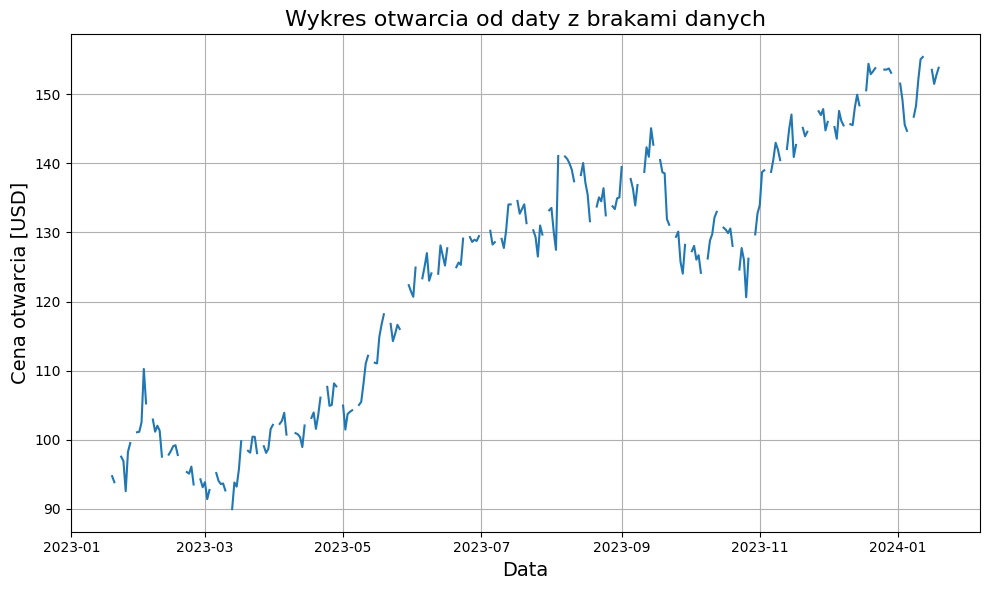

In [75]:
# Wykres 
plt.figure(figsize=(10, 6))
plt.plot(new_date, new_open)
plt.title("Wykres otwarcia od daty z brakami danych", fontsize=16)  
plt.xlabel("Data", fontsize=14)  
plt.ylabel("Cena otwarcia [USD]", fontsize=14) 
plt.grid(True)
plt.tight_layout()
plt.show()

In [76]:
# Uzupełniebie brakujących dane interpolacją liniową
new_open = np.interp(np.arange(len(new_date)), np.arange(len(new_open))[~np.isnan(new_open)], new_open[~np.isnan(new_open)]) 

# Dodanie zaktualizowanych dane do DataFrame
new_df["Open"] = new_open

# W PRAKTYCE NIE UZUPELNIAMY

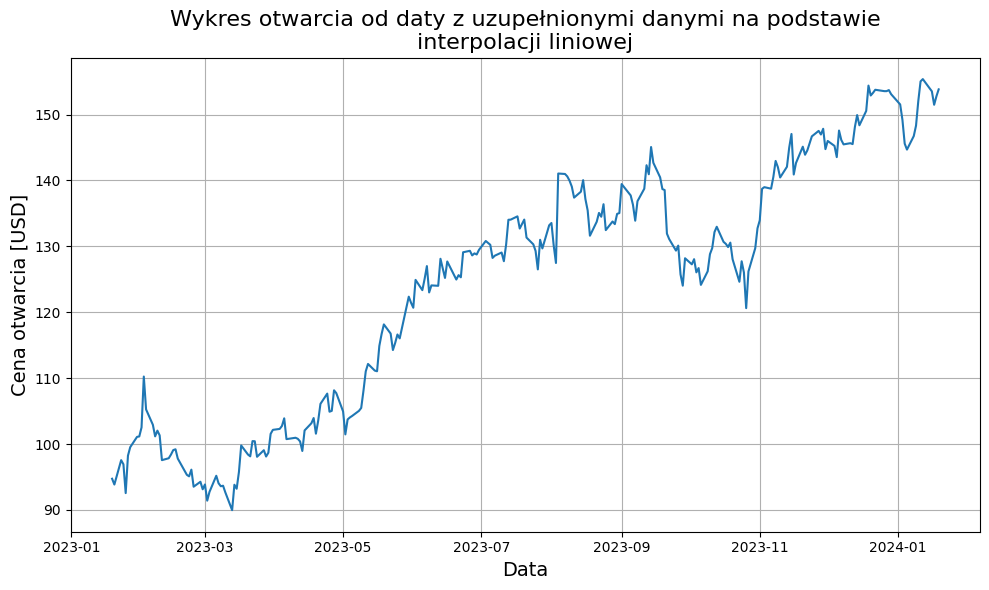

In [77]:
# Wykres
plt.figure(figsize=(10, 6))
plt.plot(new_date, new_open)
plt.title("Wykres otwarcia od daty z uzupełnionymi danymi na podstawie\ninterpolacji liniowej", fontsize=16)
plt.xlabel("Data", fontsize=14)
plt.ylabel("Cena otwarcia [USD]", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


In [78]:
new_df.to_csv("uzupełnione_dane_AMZN.csv", index=False) 

In [79]:
new_df.head()

Date       Open
0  2023-01-19  94.739998
1  2023-01-20  93.860001
2  2023-01-21  95.093333
3  2023-01-22  96.326666
4  2023-01-23  97.559998

* #  **[OPCJONALNIE] wyodrębnienie z danych obserwacji do zbioru testowego**

In [80]:
def oddziel_i_usun(df, procent_do_oddzielenia=0.1):
    ilosc_do_oddzielenia = int(procent_do_oddzielenia * len(df))

    oddzielone_wartosci = df.tail(ilosc_do_oddzielenia)

    df = df.head(len(df) - ilosc_do_oddzielenia)

    return oddzielone_wartosci, df

predict_df, new_df = oddziel_i_usun(new_df)

In [81]:
predict_df.head() # usuneliśmy date az od 15.12.2023 do konca

Date        Open
330  2023-12-15  148.380005
331  2023-12-16  149.106669
332  2023-12-17  149.833334
333  2023-12-18  150.559998
334  2023-12-19  154.399994

In [82]:
predict_open = predict_df["Open"].values
predict_dates = predict_df["Date"].values
predict_date = pd.to_datetime(predict_dates)

new_open = new_df["Open"].values
new_dates = new_df["Date"].values
new_date = pd.to_datetime(new_dates)

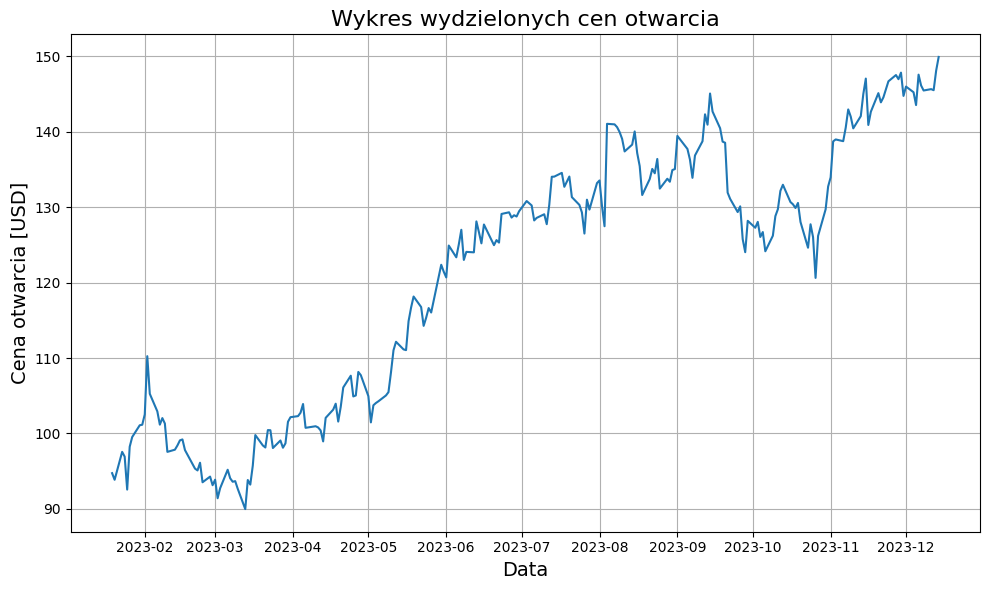

In [83]:
# Wykres
plt.figure(figsize=(10, 6))
plt.plot(new_date, new_open)
plt.title("Wykres wydzielonych cen otwarcia", fontsize=16)
plt.xlabel("Data", fontsize=14)
plt.ylabel("Cena otwarcia [USD]", fontsize=14)
plt.grid(True)
plt.tight_layout() 
plt.show()

* # **Dekompozycja szeregu czasowego**
# - wykres ACF oraz PACF dla surowych danych, 

In [84]:
h = 100 # ustawiamy duze h

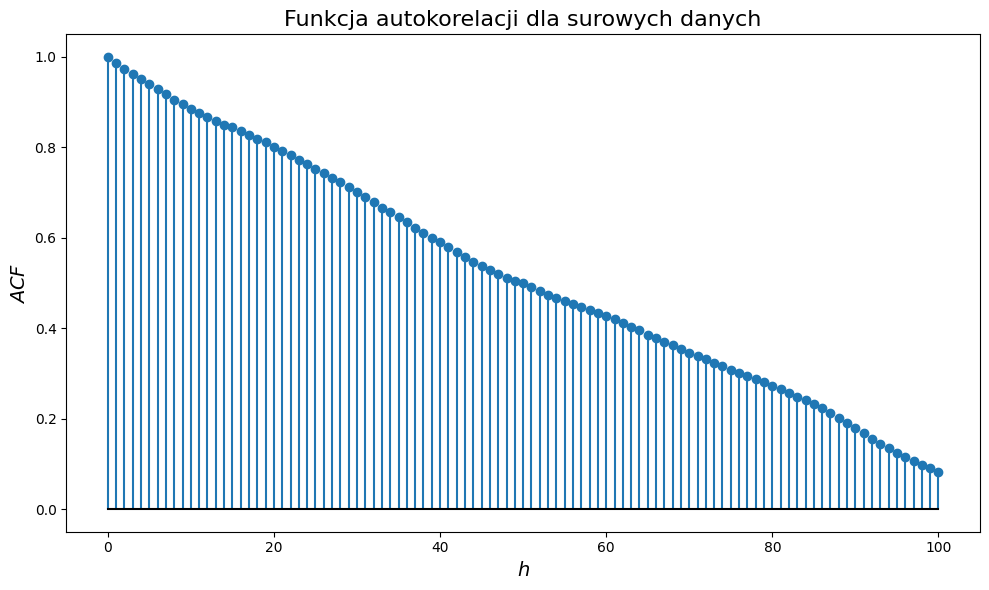

In [85]:
# Obliczenie funkcji autokorelacji 
acf_result = acf(new_open, nlags=h, fft=False)

# Wykres funkcji autokorelacji
plt.figure(figsize=(10, 6))
plt.stem(np.arange(0, h + 1), acf_result, basefmt="black")
plt.title("Funkcja autokorelacji dla surowych danych", fontsize=16)
plt.xlabel("$h$", fontsize=14)
plt.ylabel("$ACF$", fontsize=14)
plt.tight_layout()
plt.show()

# widzimy ze acf ma tendencje liniowa i spadkowa. Widoczne sa tez minimalne zachowania sugerujace sezonowosc
# ogolnie finanse normalnie nie zachowuja sezonowosci jak np pogoda, ale u nas troche przypadkowo wyszlo
# dlatego tez oprocz dekompozycji walda dokonamy roznicowania

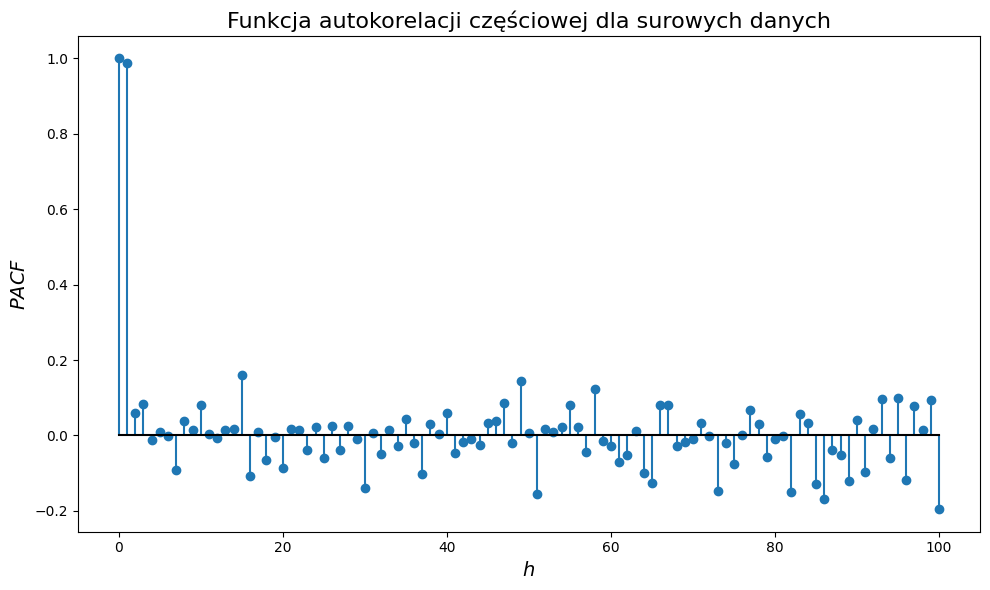

In [86]:
# Obliczenie funkcji autokorelacji częściowej
pacf_result = pacf(new_open, nlags=h)

# Wykres funkcji autokorelacji częściowej
plt.figure(figsize=(10, 6))
plt.stem(np.arange(0, h + 1), pacf_result, basefmt="black")
plt.title("Funkcja autokorelacji częściowej dla surowych danych", fontsize=16)
plt.xlabel("$h$", fontsize=14)
plt.ylabel("$PACF$", fontsize=14)
plt.tight_layout()
plt.show()

# - [OPCJONALNIE] test ADF weryfikujący hipotezę o niestacjonarności dla surowych danych (Augmented Dickey-Fuller Test),

In [87]:
# OPCJONALNE (Augmented Dickey-Fuller test)
def adfuller_test(series, sig=0.05): # kod pliku prowadzącego
    res = adfuller(series, autolag='AIC')    
    p_value = round(res[1], 3) 
    stats   = round(res[0], 3) 

    if p_value <= sig:
        print(f"Statystyka testowa = {stats}, p-Value = {p_value} => Stationary. ")
    else:
        print(f"Statystyka testowa = {stats}, p-value = {p_value} => Non-stationary.")

In [88]:
adfuller_test(new_open)

Statystyka testowa = -0.928, p-value = 0.779 => Non-stationary.


# – identyfikacja trendów deterministycznych: metody omawiane na wykładzie oraz na laboratorium 
(zadanie 4, lista 5) / różnicowanie / różnicowanie sezonowe / transformacje stabilizujące wariancję
(Boxa-Coxa),

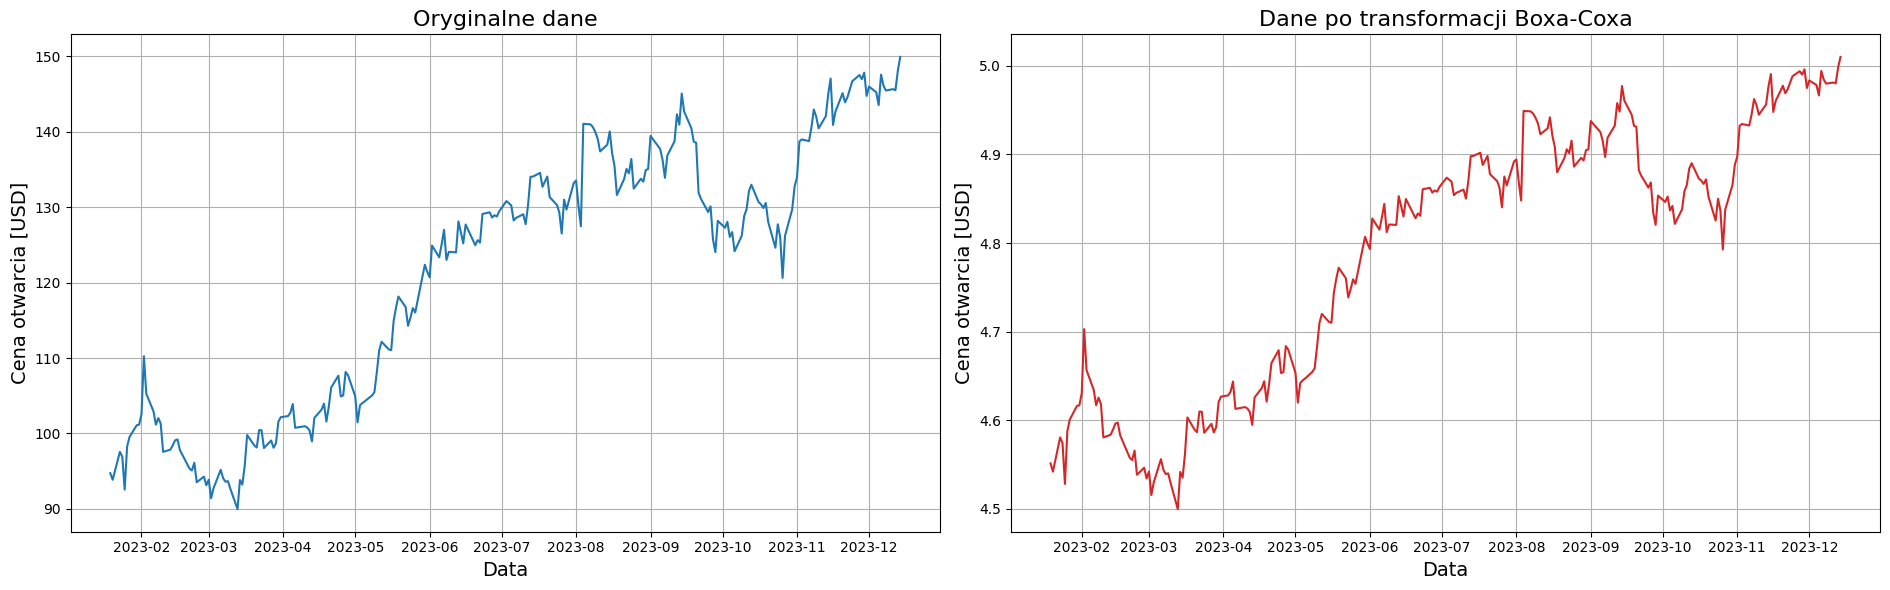

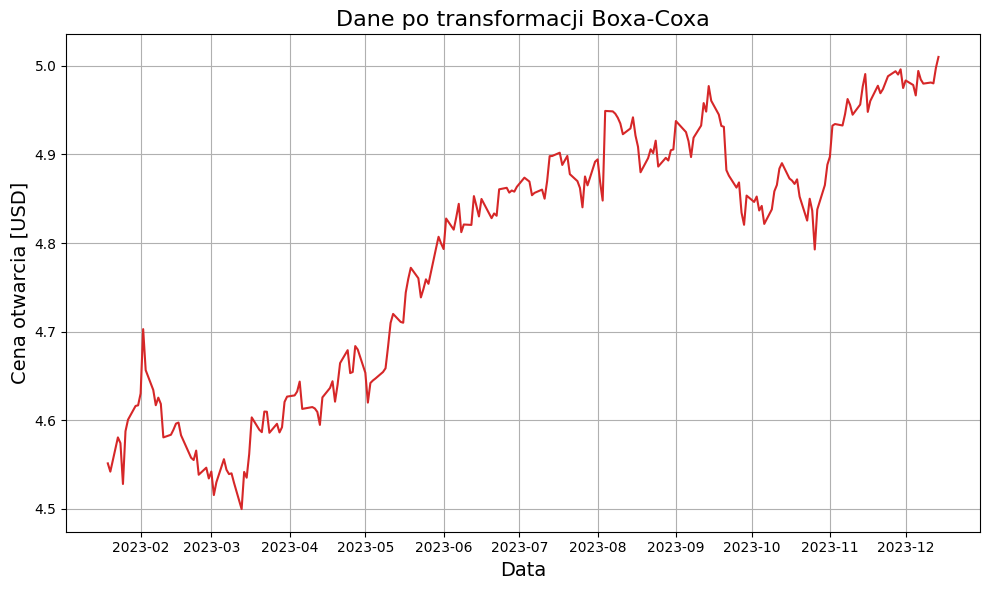

In [90]:
log_open = np.log(new_open)

# Wykres oryginalnych danych i danych po transformacji (POROWNANIE)
plt.figure(figsize=(19, 6))
# plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(new_date, new_open)
# plt.scatter(new_date, new_open, alpha=0.3)
plt.title("Oryginalne dane", fontsize=16)
plt.xlabel("Data", fontsize=14)
plt.ylabel("Cena otwarcia [USD]", fontsize=14)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(new_date, log_open, c="C3")
# plt.scatter(new_date, log_open, alpha=0.3, c="C3")
plt.title("Dane po transformacji Boxa-Coxa", fontsize=16)
plt.xlabel("Data", fontsize=14)
plt.ylabel("Cena otwarcia [USD]", fontsize=14)
plt.grid(True)

plt.tight_layout()  
plt.show()


# SAM WYKRES DANYCH PO TRANSFORMACJI BOXA COXA
plt.figure(figsize=(10, 6))
plt.plot(new_date, log_open, c="C3")
# plt.scatter(new_date, log_open, alpha=0.3, c="C3")
plt.title("Dane po transformacji Boxa-Coxa", fontsize=16)
plt.xlabel("Data", fontsize=14)
plt.ylabel("Cena otwarcia [USD]", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


# ogolnie transformacja boxa-coxa duzo nie zmienia wiec idk 

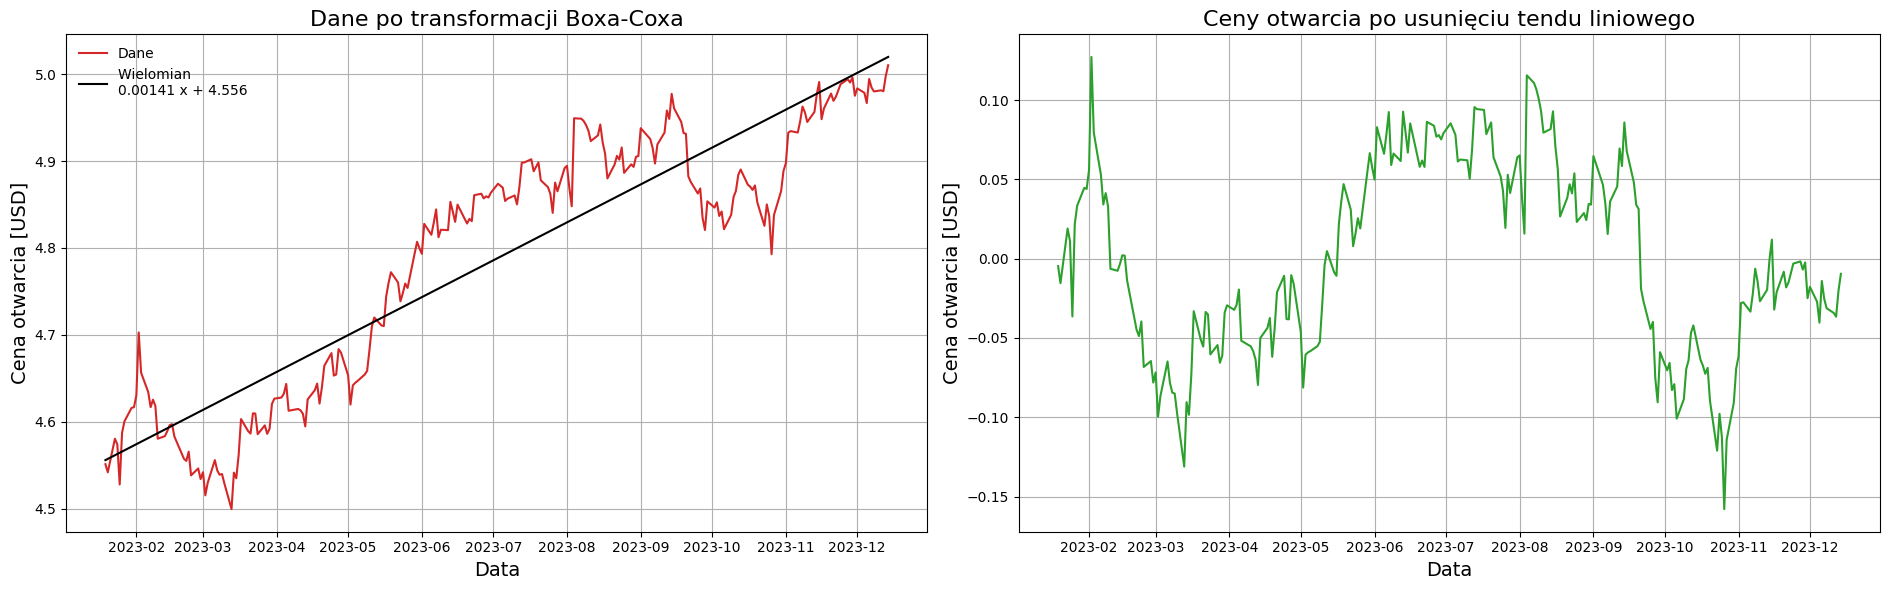

In [91]:
# Dane do interpolacji

x = np.arange(len(new_date))

# Dopasowanie wielomianu interpolacyjnego
coefficients = np.polyfit(x, log_open, 1)

# Wygenerowanie wartości dla interpolowanego wielomianu
poly_fit = np.poly1d(coefficients)
y_fit = poly_fit(x)

part_open = log_open - y_fit

# Wykres
plt.figure(figsize=(19, 6))

plt.subplot(1, 2, 1)
plt.plot(new_date, log_open, label='Dane', color='C3')
# plt.scatter(new_date, log_open, alpha=0.3, c="C3")
plt.plot(new_date, y_fit, label=f'Wielomian {poly_fit}', color="black")
plt.title("Dane po transformacji Boxa-Coxa", fontsize=16)
plt.xlabel("Data", fontsize=14)
plt.ylabel("Cena otwarcia [USD]", fontsize=14)
plt.grid(True)
plt.legend(frameon=False)



plt.subplot(1, 2, 2)
plt.plot(new_date, part_open, c="C2")
# plt.scatter(new_date, part_open, alpha=0.3, c="teal")
plt.title("Ceny otwarcia po usunięciu tendu liniowego", fontsize=16)
plt.xlabel("Data", fontsize=14)
plt.ylabel("Cena otwarcia [USD]", fontsize=14)
plt.grid(True)

plt.tight_layout()
plt.show()

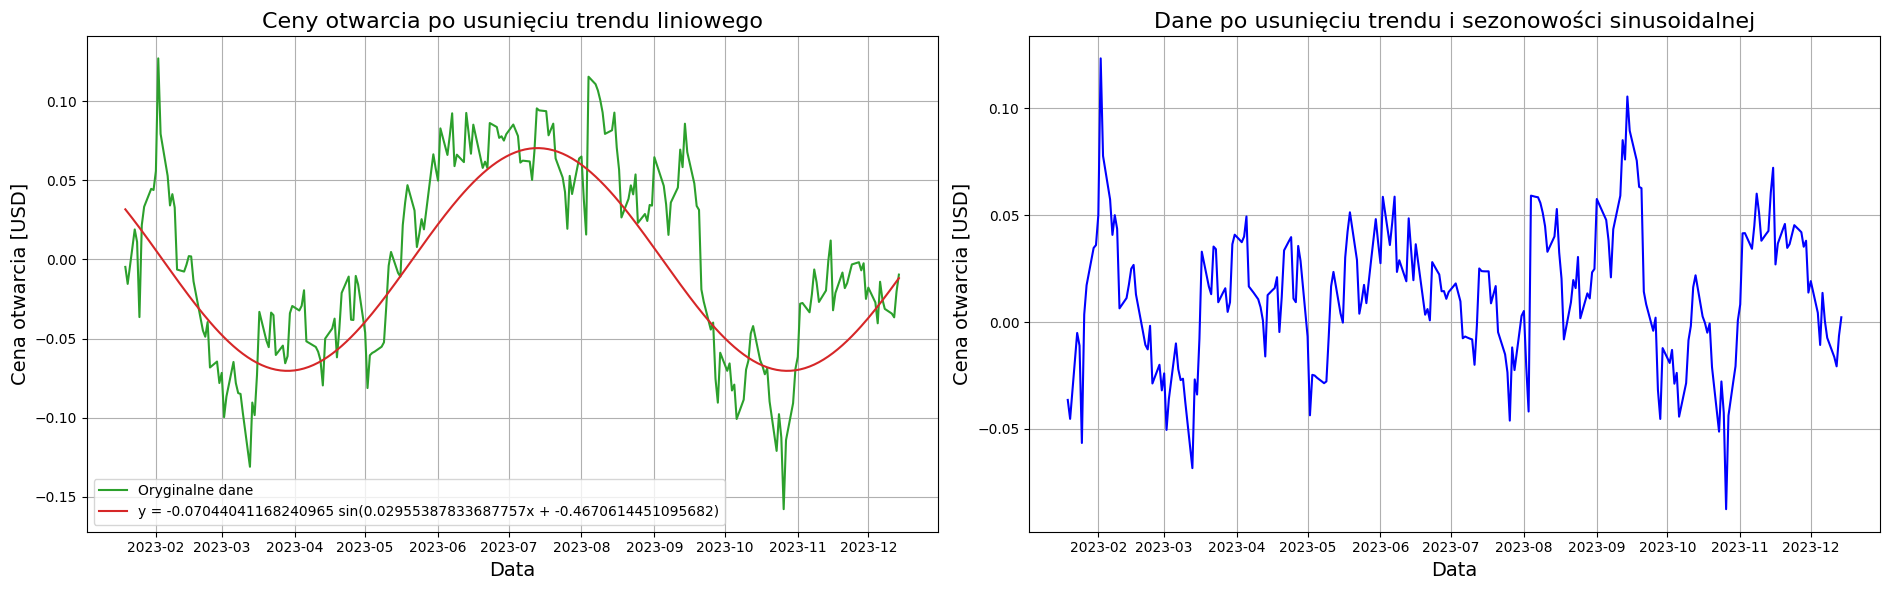

In [92]:
# Funkcja do dopasowania
def func_sin(t, c, d, e):
    return c * np.sin(d * t + e)

# Dopasowanie funkcji
c, d, e = curve_fit(func_sin, x, part_open,  p0=[21, 0.034, 0])[0]

# Wartości funkcji dopasowanej
sin_fit = func_sin(x, c, d, e)

# Odejmowanie od reszty funkcji dopasowanej
final_open_1 = part_open - sin_fit

# Wykres
plt.figure(figsize=(19, 6))

plt.subplot(1, 2, 1)
plt.plot(new_date, part_open, c="C2", label='Oryginalne dane')
plt.plot(new_date, sin_fit, c='C3', label=f"y = {c} sin({d}x + {e})")
plt.title("Ceny otwarcia po usunięciu trendu liniowego", fontsize=16)
plt.xlabel("Data", fontsize=14)
plt.ylabel("Cena otwarcia [USD]", fontsize=14)
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(new_date, final_open_1, color='b')
plt.title("Dane po usunięciu trendu i sezonowości sinusoidalnej", fontsize=16)
plt.xlabel("Data", fontsize=14)
plt.ylabel("Cena otwarcia [USD]", fontsize=14)
plt.grid(True)

plt.tight_layout()
plt.show()


C:\Users\aleks\AppData\Local\Temp\ipykernel_13116\2340114306.py:6: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(np.arange(0, h + 1), acf_result_1, "b", markerfmt = "bo", basefmt="black")


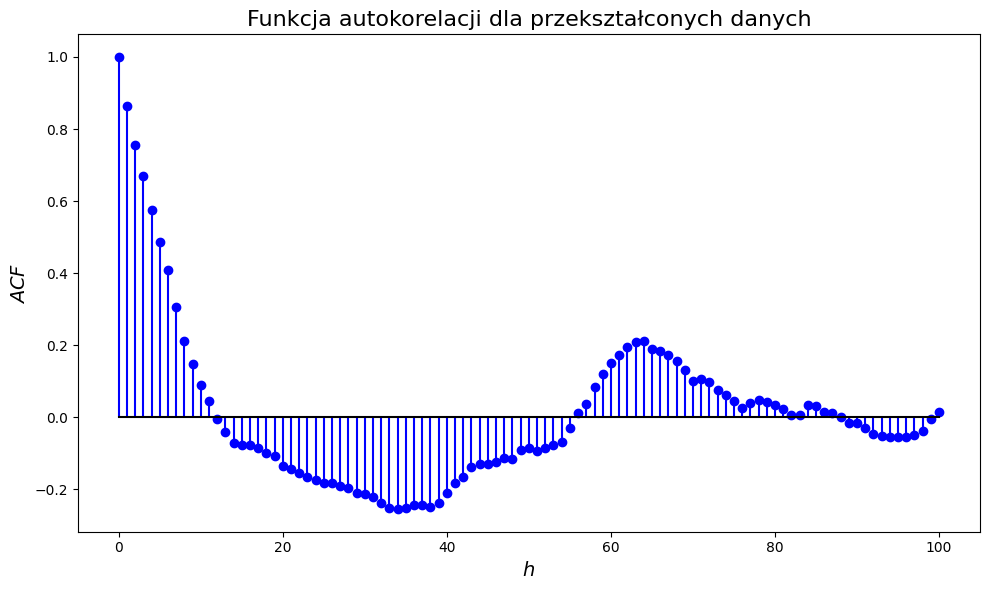

In [93]:
# Obliczenie funkcji autokorelacji
acf_result_1 = acf(final_open_1, nlags=h)

# Wykres funkcji autokorelacji
plt.figure(figsize=(10, 6))
plt.stem(np.arange(0, h + 1), acf_result_1, "b", markerfmt = "bo", basefmt="black")
plt.title("Funkcja autokorelacji dla przekształconych danych", fontsize=16)
plt.xlabel("$h$", fontsize=14)
plt.ylabel("$ACF$", fontsize=14)
plt.tight_layout()
plt.show()

# autokorelacja jest ewidentna, korelacja jest bardzo widoczna, mamy duza zaleznosc, jedynie wysypuje nam sie tam gdzie schodzi ponizej 0, czyli od okolo h = 17
# do h okolo 17 mamy bardzoo silna zaleznosc , a pozniej cos sie wywala i w przedzialach ufnosci wypadnie
# widac ze dla h = 1 mamy wartosci okolo 0.9 i to sie zgadza bardzo z dobranym parametrem
# tu wiadomo MA(1) nam nie wyjdzie i wiadomo Arma(0, 0), bo to modele malo zalezne a my mamy duza zaleznosc

C:\Users\aleks\AppData\Local\Temp\ipykernel_13116\1611100267.py:6: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(np.arange(0, h + 1), pacf_result_1, "b", markerfmt = "bo", basefmt='black')


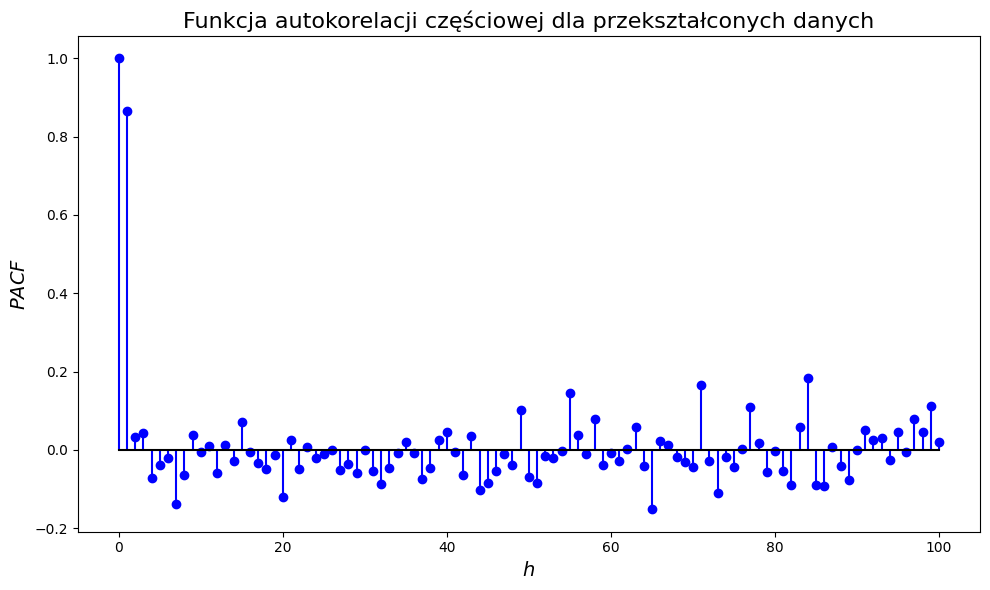

In [94]:
# Obliczenie funkcji autokorelacji częściowej
pacf_result_1 = pacf(final_open_1, nlags=h)

# Wykres funkcji autokorelacji częściowej
plt.figure(figsize=(10, 6))
plt.stem(np.arange(0, h + 1), pacf_result_1, "b", markerfmt = "bo", basefmt='black')
plt.title("Funkcja autokorelacji częściowej dla przekształconych danych", fontsize=16)
plt.xlabel("$h$", fontsize=14)
plt.ylabel("$PACF$", fontsize=14)
plt.tight_layout()
plt.show()

# ma pojedyczne wieksze odskoki (picki) ale mozna to troche pominac i zachowanie pacf sugeruje jednak ze wartosci oscyluja kolo 0 wiec git
# od h = 2 bedzie raczej sensowny wynik 

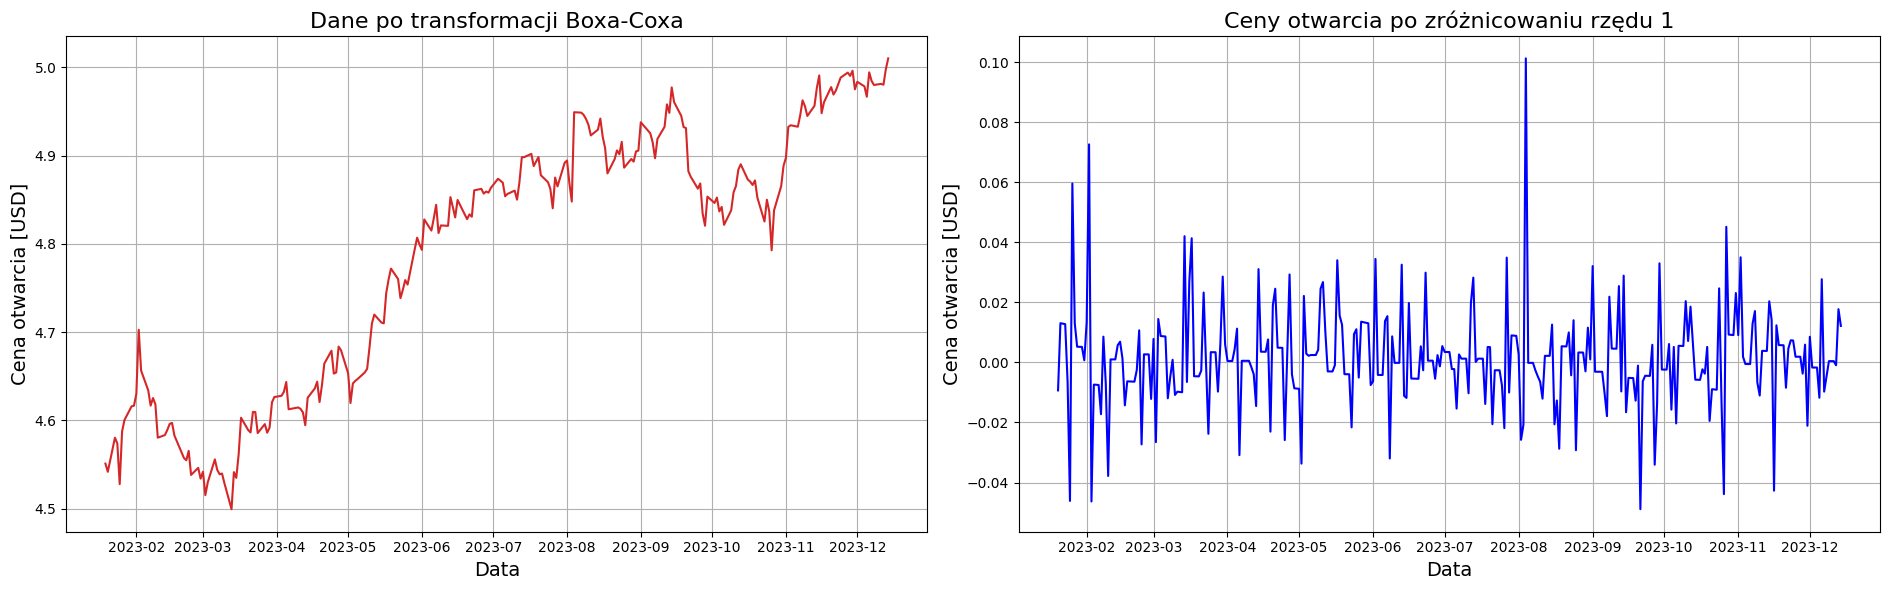

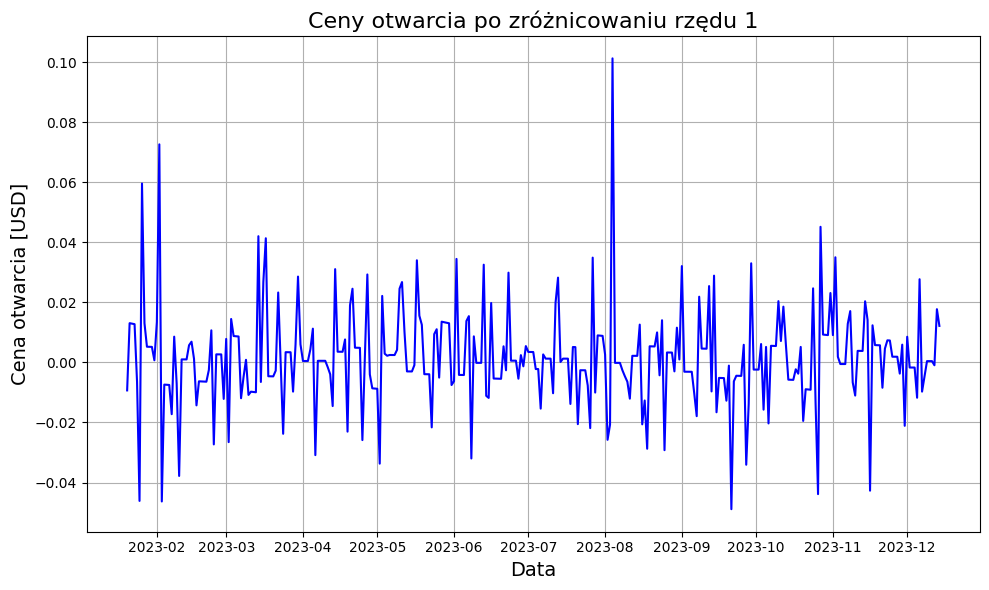

In [95]:
m = 1 # Rząd różnicowania

final_open_2 = np.diff(log_open, n=m) 
final_date = new_date[m:]


# Wykresy różnicowania rzędu m i danych po transformacji Boxa-Coxa
plt.figure(figsize=(19, 6))

plt.subplot(1, 2, 1)
plt.plot(new_date, log_open, c="C3")
plt.title("Dane po transformacji Boxa-Coxa", fontsize=16)
plt.xlabel("Data", fontsize=14)
plt.ylabel("Cena otwarcia [USD]", fontsize=14)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(final_date, final_open_2, c="b")
plt.title(f"Ceny otwarcia po zróżnicowaniu rzędu {m}", fontsize=16)
plt.xlabel("Data", fontsize=14)
plt.ylabel("Cena otwarcia [USD]", fontsize=14)
plt.grid(True)

plt.tight_layout()
plt.show()


# SAM WYKRES DANYCH
plt.figure(figsize=(10, 6))
plt.plot(final_date, final_open_2, c="b")
plt.title(f"Ceny otwarcia po zróżnicowaniu rzędu {m}", fontsize=16)
plt.xlabel("Data", fontsize=14)
plt.ylabel("Cena otwarcia [USD]", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


# widzimy ze sa tutaj pojedyncze wyskoki co moze sugerowac ze skorelowanie/zaleznosc bedzie "ukryte", informacja o zaleznosci jest ukryta

# – wykres ACF oraz PACF dla uzyskanego szeregu,

C:\Users\aleks\AppData\Local\Temp\ipykernel_13116\4125464528.py:6: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(np.arange(0, h + 1), acf_result_2, "b", markerfmt = "bo", basefmt="black")


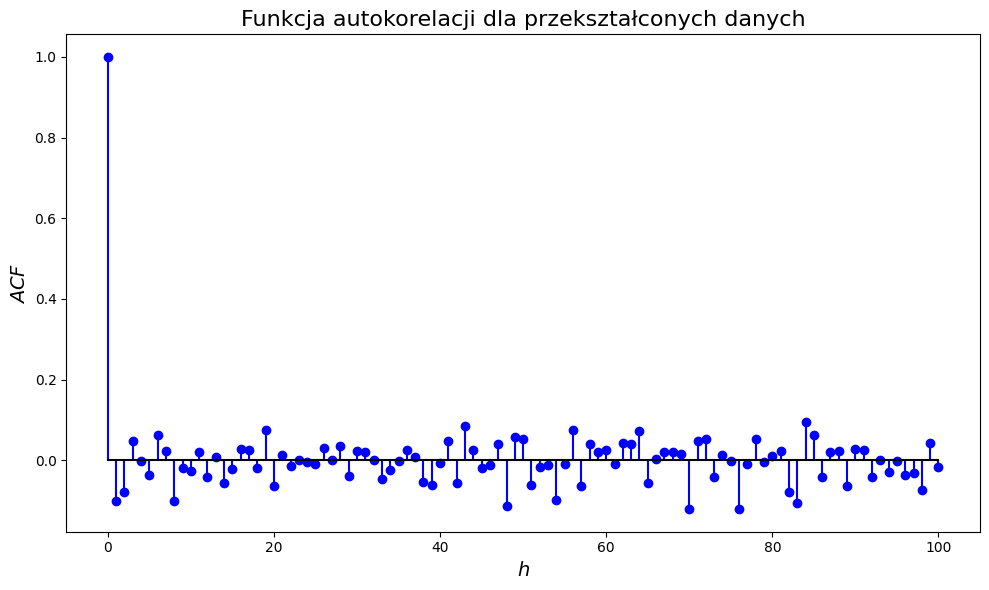

In [96]:
# Obliczenie funkcji autokorelacji, (jak by wyglądała funkcja autokorelacji odporna?)
acf_result_2 = acf(final_open_2, nlags=h)

# Wykres funkcji autokorelacji
plt.figure(figsize=(10, 6))
plt.stem(np.arange(0, h + 1), acf_result_2, "b", markerfmt = "bo", basefmt="black")
plt.title("Funkcja autokorelacji dla przekształconych danych", fontsize=16)
plt.xlabel("$h$", fontsize=14)
plt.ylabel("$ACF$", fontsize=14)
plt.tight_layout()
plt.show()

# funkcja autokorelacji zachowuje sie dobrze, wartosci sa bliskie 0, a wiec moze wyjsc nam Arma(0, 0)(czyli bialy szum), albo wspolczynniki sa na tyle male ze nie widac roznicy
# ( zaleznosci tutaj wielkiej nie ma albo jest minimalna)

C:\Users\aleks\AppData\Local\Temp\ipykernel_13116\116929834.py:6: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(np.arange(0, h + 1), pacf_result_2, "b", markerfmt = "bo", basefmt='black')


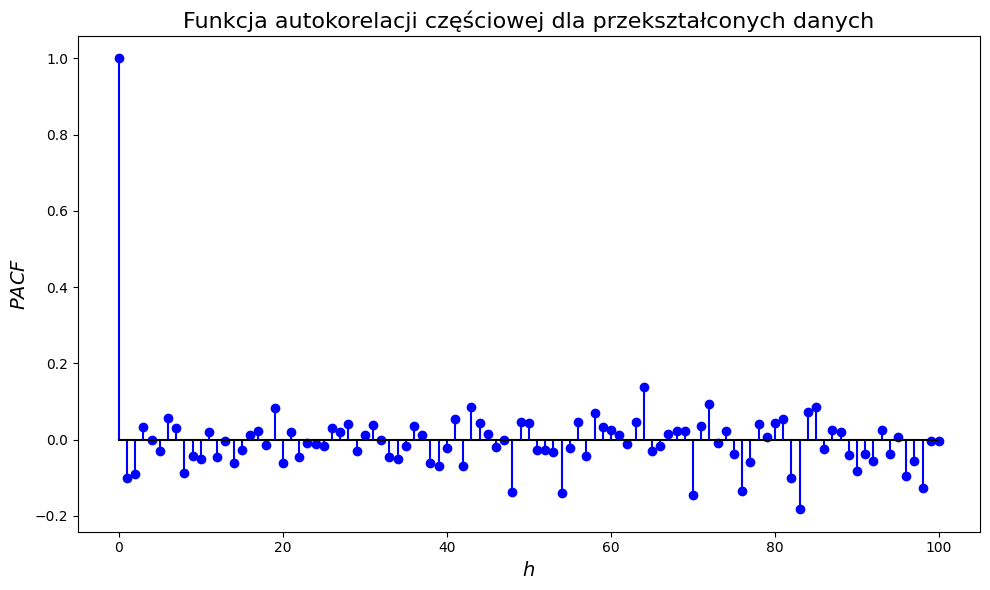

In [97]:
# Obliczenie funkcji autokorelacji częściowej
pacf_result_2 = pacf(final_open_2, nlags=h)

# Wykres funkcji autokorelacji częściowej
plt.figure(figsize=(10, 6))
plt.stem(np.arange(0, h + 1), pacf_result_2, "b", markerfmt = "bo", basefmt='black')
plt.title("Funkcja autokorelacji częściowej dla przekształconych danych", fontsize=16)
plt.xlabel("$h$", fontsize=14)
plt.ylabel("$PACF$", fontsize=14)
plt.tight_layout()
plt.show()

# wartosci bliskie 0, wnioski podobne jak wyzej ( zaleznosci tutaj wielkiej nie ma albo jest minimalna)
# raczej jakby na to nie patrzec arma(0, 0) moze byc lepiej dobranym modelem niz Ma(1), bo zaleznosci sa jak juz znikome 

### ESTYMATOR AUTOKORELACJI KTORY JEST ODPORNY

In [98]:
# quadric corr( ten z zajec)
def quadric_acf(x, h):
    n = len(x)
    result = np.zeros(len(h))

    for k in range(len(h)):
        est_gamma = 0

        for i in range(n - h[k]):
            est_gamma += np.sign((x[i] - np.median(x)) * (x[i + h[k]] - np.median(x)))

        result[k] = (1 / (n - h[k])) * est_gamma

    return np.sin((np.pi * result) / 2)

C:\Users\aleks\AppData\Local\Temp\ipykernel_13116\775269627.py:5: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(np.arange(0, h + 1), resist_acf, "b", markerfmt = "bo", basefmt="black")


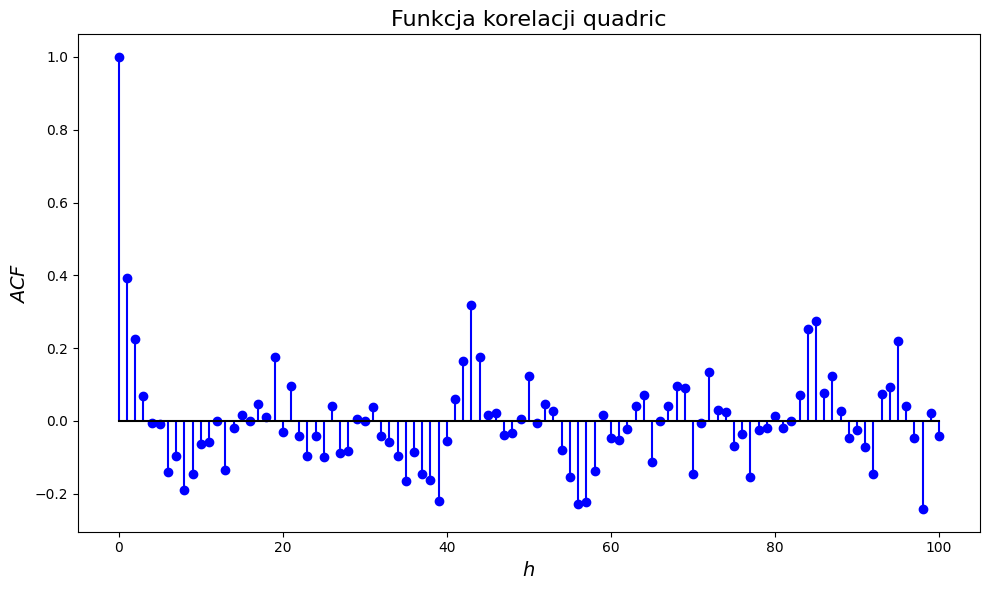

In [99]:
resist_acf = quadric_acf(final_open_2, np.arange(0, h+1))


plt.figure(figsize=(10, 6))
plt.stem(np.arange(0, h + 1), resist_acf, "b", markerfmt = "bo", basefmt="black")
plt.title("Funkcja korelacji quadric", fontsize=16)
plt.xlabel("$h$", fontsize=14)
plt.ylabel("$ACF$", fontsize=14)
plt.tight_layout()
plt.show()

# tutaj wystepuje jakas zaleznosc

C:\Users\aleks\AppData\Local\Temp\ipykernel_13116\1218572153.py:18: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(np.arange(0, h + 1), np.array(2)*np.sin(resist_acf_2*np.array(np.pi/6)), "b", markerfmt = "bo", basefmt="black")


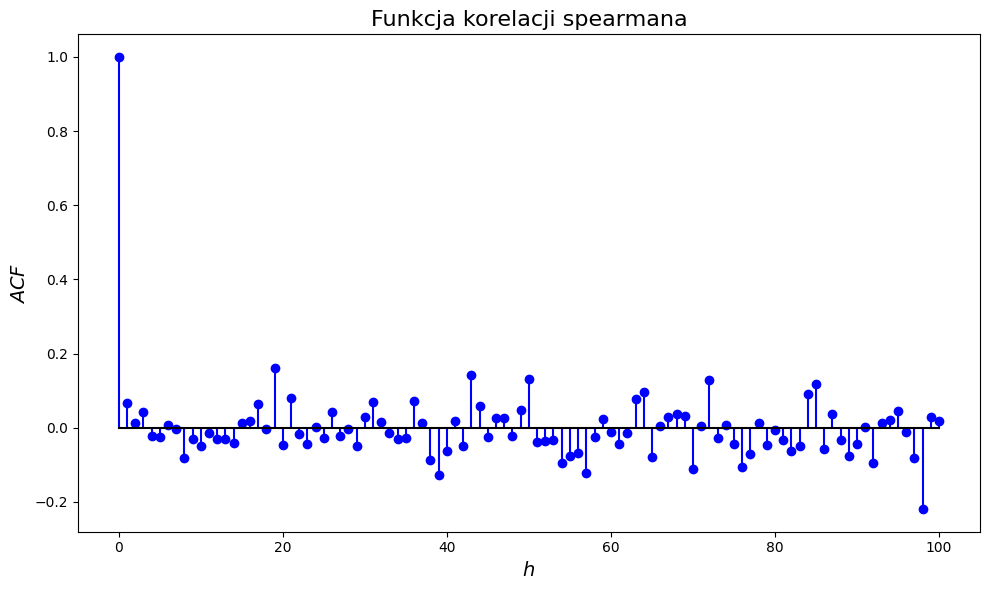

In [100]:
from scipy.stats import spearmanr

def acf_spearman(data, lag):
    n = len(data)
    acf_values = []

    for i in range(lag + 1):
        x = data[:n - i]
        y = data[i:]
        rho, _ = spearmanr(x, y)
        acf_values.append(rho)

    return acf_values

resist_acf_2 = acf_spearman(final_open_2, h)

plt.figure(figsize=(10, 6))
plt.stem(np.arange(0, h + 1), np.array(2)*np.sin(resist_acf_2*np.array(np.pi/6)), "b", markerfmt = "bo", basefmt="black")
plt.title("Funkcja korelacji spearmana", fontsize=16)
plt.xlabel("$h$", fontsize=14)
plt.ylabel("$ACF$", fontsize=14)
plt.tight_layout()
plt.show()


# tu nie

In [101]:
# korelacja kendalla
def Kendall(x, h):
    n = len(x)
    res = 0
    for j in range(n - h - 1):
        for i in range(j, n -h):
            res += np.sign((x[i] - x[j])*(x[i+h] - x[j+h]))
    
    result = (2/((n - h)*(n - h - 1)))*res

    return result

In [102]:
resist_acf_3 = [np.sin((np.pi*Kendall(final_open_2, nlag))/2) for nlag in range(0, h + 1)]

C:\Users\aleks\AppData\Local\Temp\ipykernel_13116\3210276525.py:2: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(np.arange(0, h + 1), resist_acf_3, "b", markerfmt = "bo", basefmt="black")


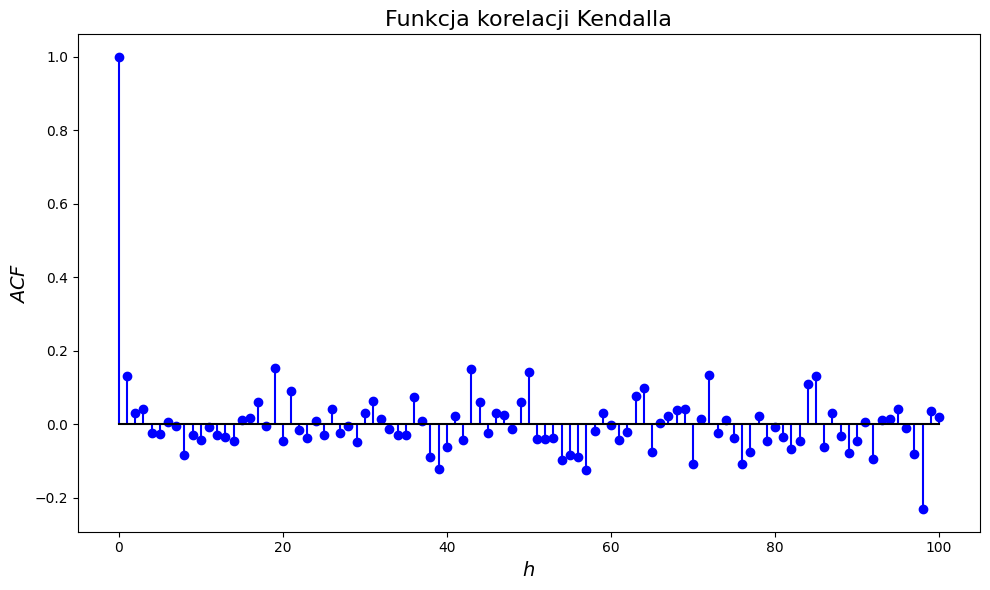

In [103]:
plt.figure(figsize=(10, 6))
plt.stem(np.arange(0, h + 1), resist_acf_3, "b", markerfmt = "bo", basefmt="black")
plt.title("Funkcja korelacji Kendalla", fontsize=16)
plt.xlabel("$h$", fontsize=14)
plt.ylabel("$ACF$", fontsize=14)
plt.tight_layout()
plt.show()

# jakies wielkiej zaleznosci nie ma!

# – [OPCJONALNIE] test ADF weryfikujący hipotezę o niestacjonarności dla uzyskanego szeregu (Augmented Dickey-Fuller Test).

In [104]:
adfuller_test(final_open_1) 

Statystyka testowa = -4.946, p-Value = 0.0 => Stationary. 


In [105]:
adfuller_test(final_open_2) 

Statystyka testowa = -19.96, p-Value = 0.0 => Stationary. 


In [106]:
# nie za bardzo ten test super dziala i to co mowi nie musi oznaczac prawdy
# jest ukierunkowany najbardziej na wystepowanie trendu stad jego wywrotki 

# ale i tak stwierdzamy stacjonarnosc danych 

## **2. Modelowanie danych przy pomocy ARMA**

# -  dobranie rzędu modelu (kryteria informacyjne),- p, q

In [107]:
def func(data, max_p, max_q):
    df = pd.DataFrame()
    ps = []
    qs = []
    BIC = []
    AIC = []
    HQIC = []

    for p in range(0, max_p + 1):
        for q in range(0, max_q + 1):
            model = ARIMA(data, order=(p, 0, q))
            model_fit = model.fit()
            ps.append(p)
            qs.append(q)
            AIC.append(model_fit.aic)
            BIC.append(model_fit.bic)
            HQIC.append(model_fit.hqic)

    df['p']    = ps
    df['q']    = qs
    df['AIC']  = AIC
    df['BIC']  = BIC
    df['HQIC'] = HQIC
    
    return df

In [108]:
df_1 = func(final_open_1, 5, 5)
df_2 = func(final_open_2, 5, 5)

c:\Users\aleks\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\aleks\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\aleks\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\aleks\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn

In [109]:
df_1.sort_values(by='BIC').head() # wyszedl nam wszedzie model AR(1), ktory jest silnie zalezny i obliczony nizej wspolczynnik jest tez bardzo duzy wiec git

p  q          AIC          BIC         HQIC
6   1  0 -1804.023336 -1792.626058 -1799.477127
7   1  1 -1802.665111 -1787.468740 -1796.603499
12  2  0 -1802.591450 -1787.395080 -1796.529839
18  3  0 -1801.233369 -1782.237905 -1793.656354
8   1  2 -1801.005964 -1782.010501 -1793.428950

In [110]:
df_1.sort_values(by='AIC').head() # to samo co wyzej

p  q          AIC          BIC         HQIC
6   1  0 -1804.023336 -1792.626058 -1799.477127
26  4  2 -1803.220055 -1772.827314 -1791.096832
7   1  1 -1802.665111 -1787.468740 -1796.603499
12  2  0 -1802.591450 -1787.395080 -1796.529839
18  3  0 -1801.233369 -1782.237905 -1793.656354

In [111]:
df_1.sort_values(by='HQIC').head() # to samo

p  q          AIC          BIC         HQIC
6   1  0 -1804.023336 -1792.626058 -1799.477127
7   1  1 -1802.665111 -1787.468740 -1796.603499
12  2  0 -1802.591450 -1787.395080 -1796.529839
18  3  0 -1801.233369 -1782.237905 -1793.656354
8   1  2 -1801.005964 -1782.010501 -1793.428950

In [112]:
df_2.sort_values(by='AIC').head() # wyszedl nam model o malej wartosci parametru theta, zaleznosc bedzie malutka

p  q          AIC          BIC         HQIC
1   0  1 -1779.327221 -1767.939048 -1774.784153
12  2  0 -1779.321331 -1764.137099 -1773.263907
2   0  2 -1778.875077 -1763.690846 -1772.817653
6   1  0 -1778.712941 -1767.324768 -1774.169873
7   1  1 -1778.093162 -1762.908931 -1772.035738

In [113]:
df_2.sort_values(by='BIC').head() # brak zaleznosic, bialy szum

p  q          AIC          BIC         HQIC
0   0  0 -1777.420631 -1769.828515 -1774.391919
1   0  1 -1779.327221 -1767.939048 -1774.784153
6   1  0 -1778.712941 -1767.324768 -1774.169873
12  2  0 -1779.321331 -1764.137099 -1773.263907
2   0  2 -1778.875077 -1763.690846 -1772.817653

In [114]:
df_2.sort_values(by='HQIC').head() # brak zaleznosci, bialy szum

p  q          AIC          BIC         HQIC
1   0  1 -1779.327221 -1767.939048 -1774.784153
0   0  0 -1777.420631 -1769.828515 -1774.391919
6   1  0 -1778.712941 -1767.324768 -1774.169873
12  2  0 -1779.321331 -1764.137099 -1773.263907
2   0  2 -1778.875077 -1763.690846 -1772.817653

In [115]:
# aic i bic rozni sie tym jak wysoka jest kara nalozona na modele o wiekszym skomplikowaniu
# celem jest znalezienie najprostszego rozwiazania 
# bic naklada wieksza kare na liczbe parametrow niz aic

In [116]:
p_best_1 = 1
q_best_1 = 0

p_best_2 = 0
q_best_2 = 1

# - estymacja parametrów modelu wybraną metodą

In [117]:
y_1 = final_open_1 
model_1 = ARIMA(y_1, order=(p_best_1, 0, q_best_1)).fit()

print(model_1.summary()) #ogólne "podsumowanie" dobranego modelu

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  330
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 905.012
Date:                Fri, 02 Feb 2024   AIC                          -1804.023
Time:                        12:10:39   BIC                          -1792.626
Sample:                             0   HQIC                         -1799.477
                                - 330                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0124      0.006      1.940      0.052      -0.000       0.025
ar.L1          0.8646      0.021     40.708      0.000       0.823       0.906
sigma2         0.0002   9.96e-06     24.268      0.0

c:\Users\aleks\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [118]:
y_2 = final_open_2 
model_2 = ARIMA(y_2, order=(p_best_2, 0, q_best_2)).fit()

print(model_2.summary()) #ogólne "podsumowanie" dobranego modelu

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  329
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 892.664
Date:                Fri, 02 Feb 2024   AIC                          -1779.327
Time:                        12:10:39   BIC                          -1767.939
Sample:                             0   HQIC                         -1774.784
                                - 329                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      1.690      0.091      -0.000       0.003
ma.L1         -0.1175      0.044     -2.650      0.008      -0.204      -0.031
sigma2         0.0003   1.17e-05     22.055      0.0

In [119]:
y_2_2 = final_open_2
model_2_2 = ARIMA(y_2_2, order=(0, 0, 0)).fit()

print(model_2_2.summary()) #ogólne "podsumowanie" dobranego modelu

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  329
Model:                          ARIMA   Log Likelihood                 890.710
Date:                Fri, 02 Feb 2024   AIC                          -1777.421
Time:                        12:10:39   BIC                          -1769.829
Sample:                             0   HQIC                         -1774.392
                                - 329                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      1.481      0.139      -0.000       0.003
sigma2         0.0003   1.07e-05     24.386      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   3.31   Jarque-

In [120]:
params_1 = model_1.params #wartosci współczynników dobranego modelu (w kolejnosci jak w summary: stała, współczynniki phi, współczynniki theta, sigma^2)
residuals_1 = model_1.resid #wektor residuów

params_2 = model_2.params #wartosci współczynników dobranego modelu (w kolejnosci jak w summary: stała, współczynniki phi, współczynniki theta, sigma^2)
residuals_2 = model_2.resid #wektor residuów

params_2_2 = model_2_2.params #wartosci współczynników dobranego modelu (w kolejnosci jak w summary: stała, współczynniki phi, współczynniki theta, sigma^2)
residuals_2_2 = model_2_2.resid #wektor residuów

ar_params = model_1.arparams
ma_params = model_2.maparams

print(f"Wspołczynnik phi: {ar_params[0]}")
print(f"Wspołczynnik theta: {ma_params[0]}")

Wspołczynnik phi: 0.8645734834973274
Wspołczynnik theta: -0.11754553890279275


In [121]:
def AR_1(sigma2, phi, n):
    # Generowanie procesu AR(1)
    Z_t = np.random.normal(0, np.sqrt(sigma2), n)

    X_t = np.zeros(n)
    X_t[0] = final_open_1[0]
    
    for t in range(1, n):
        X_t[t] = phi * X_t[t - 1] + Z_t[t]

    return X_t

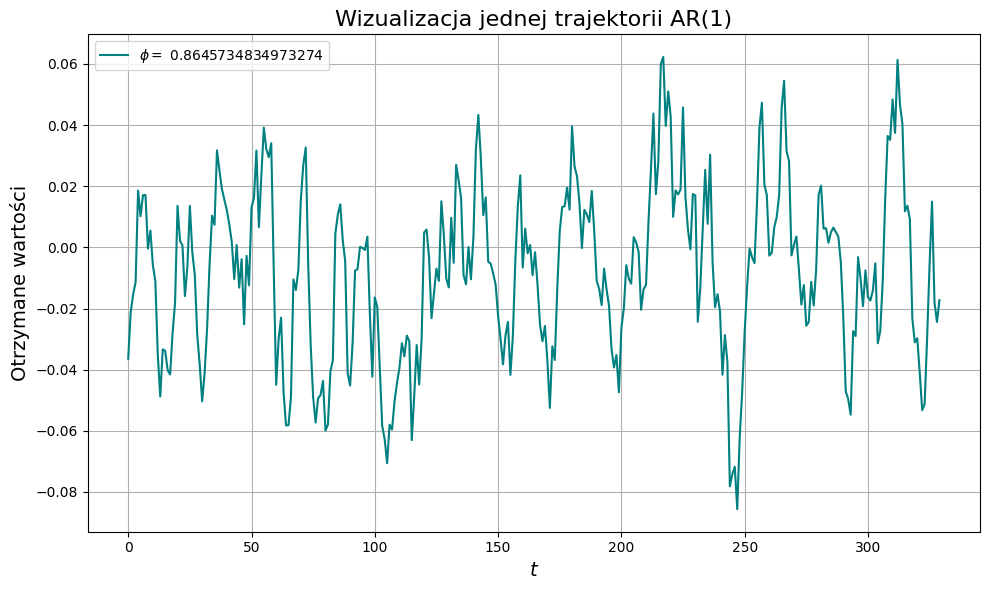

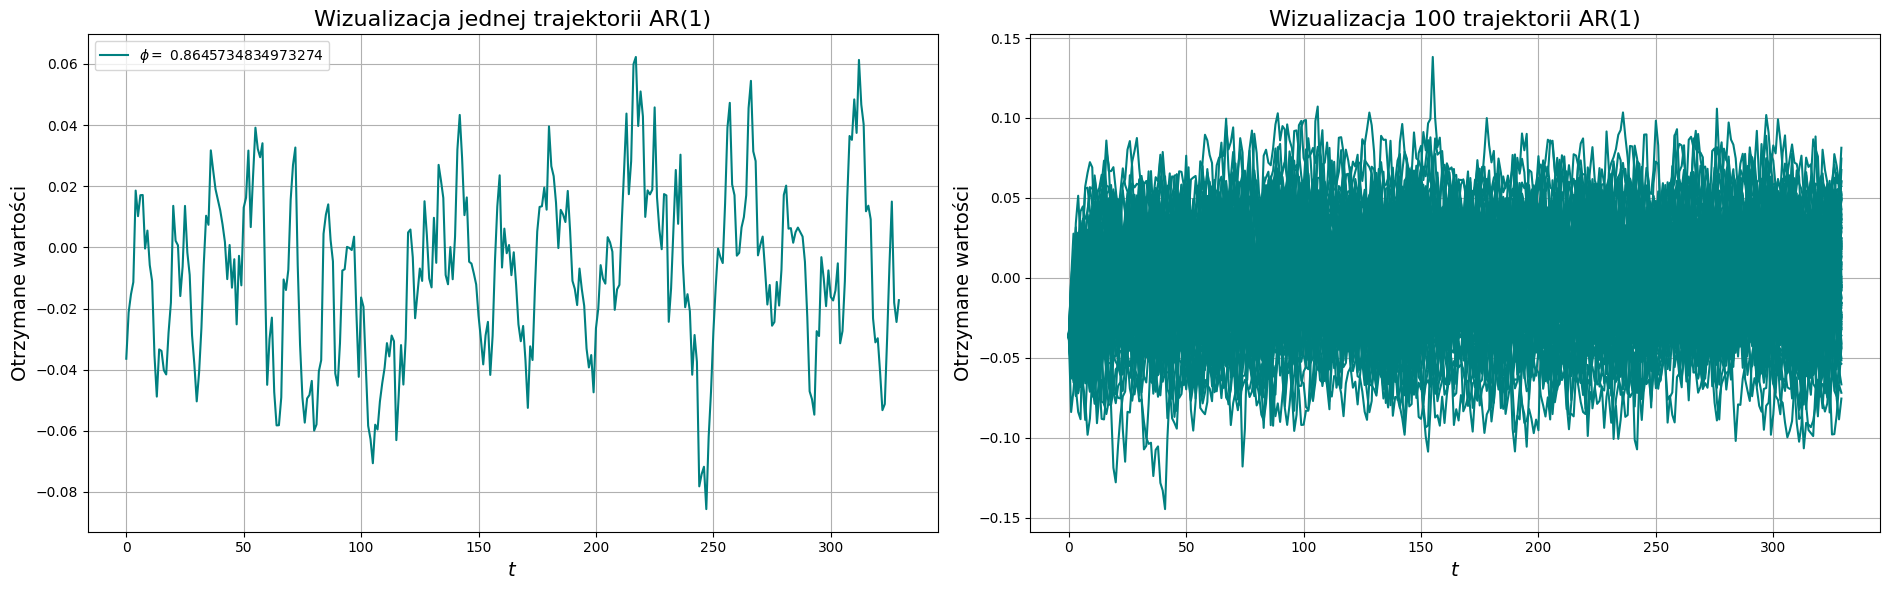

In [122]:
# Parametry modelu AR(1), to nam niewiele mowi
phi = ar_params[0]   # Parametr AR(1)
sigma2_ar = params_1[2]
# print(phi, sigma2)

X_t = AR_1(sigma2_ar, phi, len(new_date))


# Rysowanie wykresu  
plt.figure(figsize=(10, 6)) 
    
plt.plot(np.arange(0, len(X_t)), X_t, label=f'$\phi =$ {phi}', c='teal')
plt.title("Wizualizacja jednej trajektorii AR(1)", fontsize=16)
plt.xlabel("$t$", fontsize=14)
plt.ylabel("Otrzymane wartości", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Rysowanie wykresu  
plt.figure(figsize=(19, 6)) 
   
plt.subplot(1, 2, 1)   
plt.plot(np.arange(0, len(X_t)), X_t, label=f'$\phi =$ {phi}', c='teal')
plt.title("Wizualizacja jednej trajektorii AR(1)", fontsize=16)
plt.xlabel("$t$", fontsize=14)
plt.ylabel("Otrzymane wartości", fontsize=14)
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)   
for _ in range(100): 
    # Generowanie procesu AR(1)
    X_t = AR_1(sigma2_ar, phi, len(new_date))
    plt.plot(np.arange(0, len(X_t)), X_t, c='teal')

plt.title("Wizualizacja 100 trajektorii AR(1)", fontsize=16)
plt.xlabel("$t$", fontsize=14)
plt.ylabel("Otrzymane wartości", fontsize=14)
plt.grid(True)


plt.tight_layout()
plt.show()

In [123]:
def MA_1(theta, sigma2, n):
    Z = np.random.normal(0, np.sqrt(sigma2), n + 1)

    # trajektoria szeregu czasowego MA(1)
    X = np.zeros(n)
    for t in range(1, n + 1):
        X[t - 1] = Z[t] + theta*Z[t - 1]
    
    return X

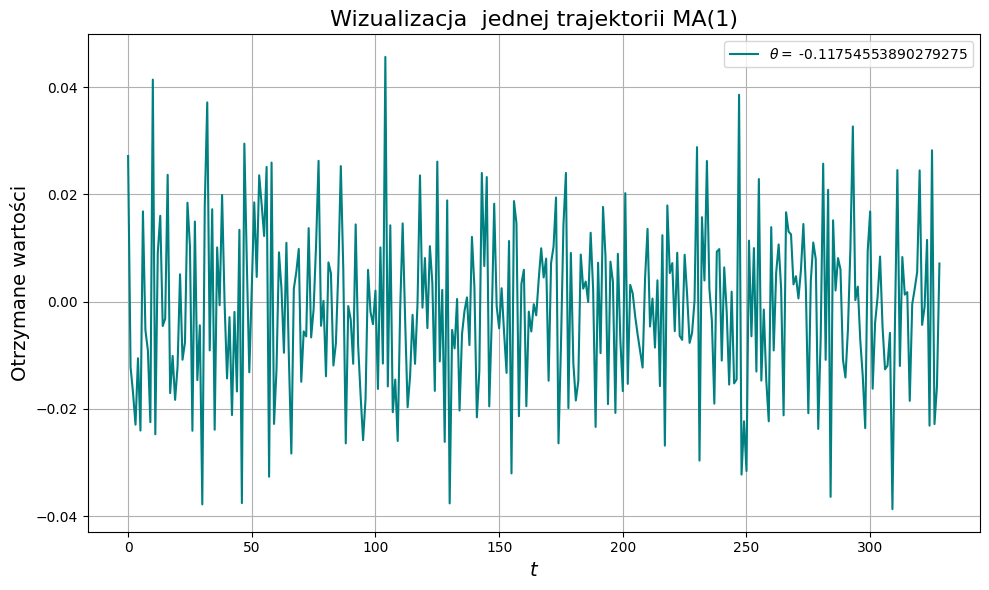

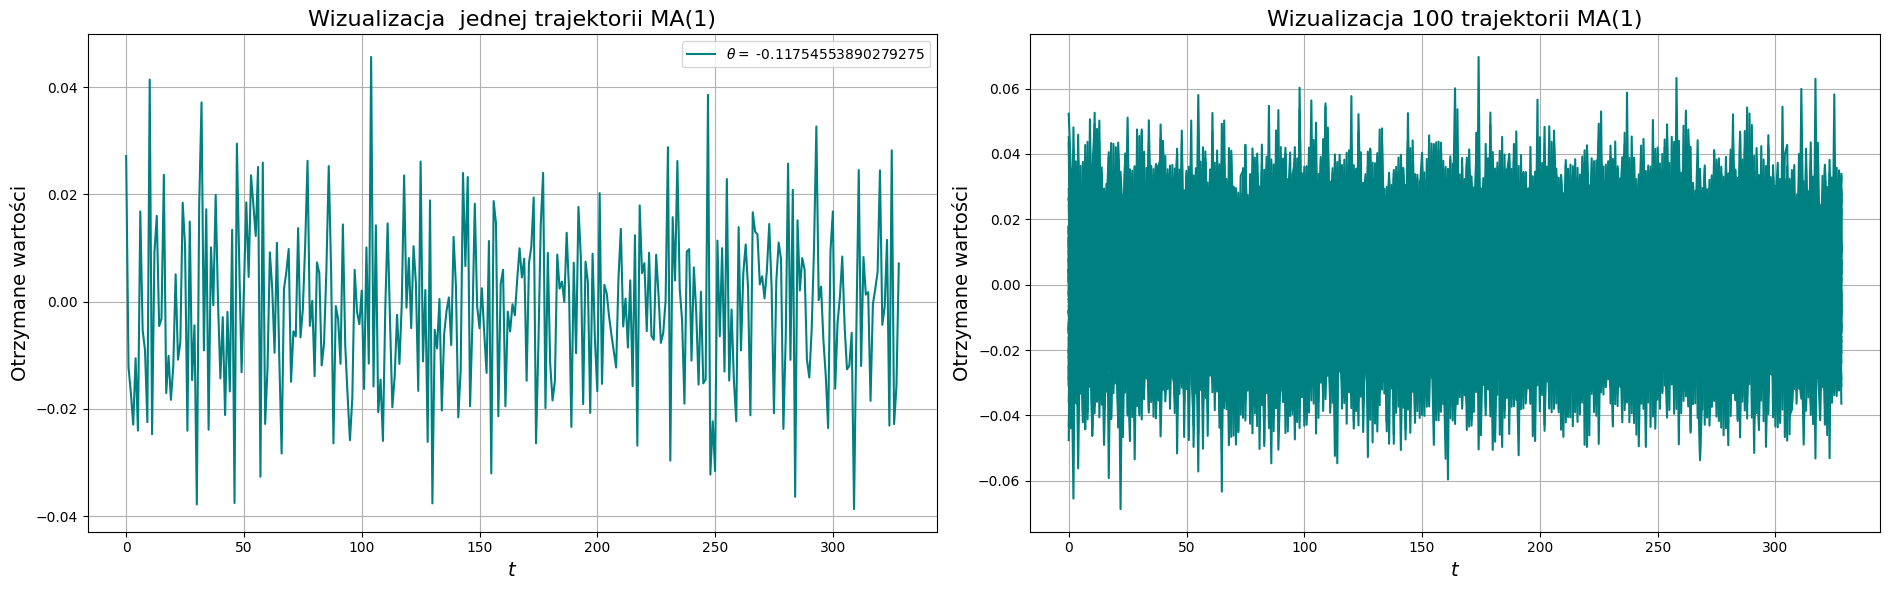

In [124]:
theta = ma_params[0]  # Parametr MA(1)
sigma2_ma = params_2[2]

X = MA_1(theta, sigma2_ma, len(final_date))

# Rysowanie wykresu  
plt.figure(figsize=(10, 6))  

plt.plot(np.arange(0, len(X)), X, label=f'$\\theta =$ {theta}', c='teal')
plt.title("Wizualizacja  jednej trajektorii MA(1)", fontsize=16)
plt.xlabel("$t$", fontsize=14)
plt.ylabel("Otrzymane wartości", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# Rysowanie wykresu  
plt.figure(figsize=(19, 6))  

plt.subplot(1, 2, 1)
plt.plot(np.arange(0, len(X)), X, label=f'$\\theta =$ {theta}', c='teal')
plt.title("Wizualizacja  jednej trajektorii MA(1)", fontsize=16)
plt.xlabel("$t$", fontsize=14)
plt.ylabel("Otrzymane wartości", fontsize=14)
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)   
for _ in range(100): 
    X = MA_1(theta, sigma2_ma, len(final_date))

    plt.plot(np.arange(0, len(X)), X, c='teal')

plt.title("Wizualizacja 100 trajektorii MA(1)", fontsize=16)
plt.xlabel("$t$", fontsize=14)
plt.ylabel("Otrzymane wartości", fontsize=14)
plt.grid(True)


plt.tight_layout()
plt.show()

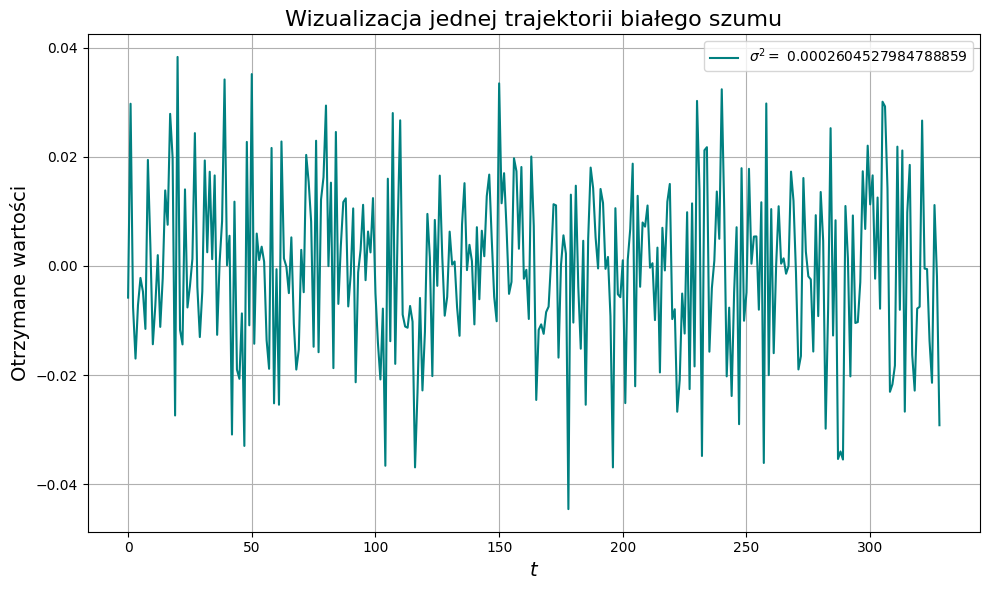

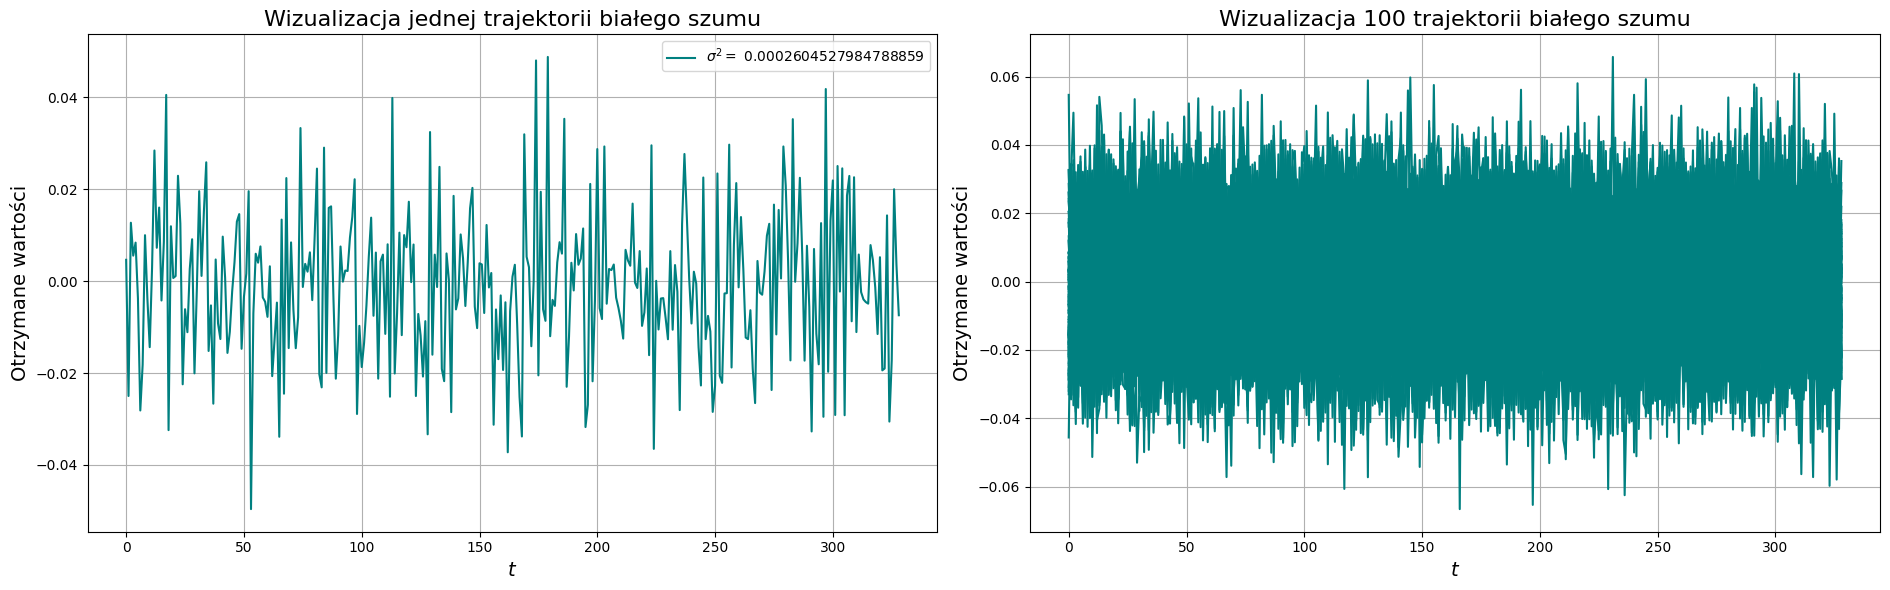

In [125]:
# ARMA(0,0), czyli white noise
sigma2_wn = params_2_2[-1]
Z = np.random.normal(0, np.sqrt(sigma2_wn), len(final_date))

# Rysowanie wykresu  
plt.figure(figsize=(10, 6))  

plt.plot(np.arange(0, len(Z)), Z, label=f'$\\sigma^2=$ {sigma2_wn}', c='teal')
plt.title("Wizualizacja jednej trajektorii białego szumu", fontsize=16)
plt.xlabel("$t$", fontsize=14)
plt.ylabel("Otrzymane wartości", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# Rysowanie wykresu  
plt.figure(figsize=(19, 6))  

plt.subplot(1, 2, 1)
plt.plot(np.arange(0, len(X)), X, label=f'$\\sigma^2=$ {sigma2_wn}', c='teal')
plt.title("Wizualizacja jednej trajektorii białego szumu", fontsize=16)
plt.xlabel("$t$", fontsize=14)
plt.ylabel("Otrzymane wartości", fontsize=14)
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)   
for _ in range(100): 
    Z = np.random.normal(0, np.sqrt(sigma2_wn), len(final_date))

    plt.plot(np.arange(0, len(Z)), Z, c='teal')

plt.title("Wizualizacja 100 trajektorii białego szumu", fontsize=16)
plt.xlabel("$t$", fontsize=14)
plt.ylabel("Otrzymane wartości", fontsize=14)
plt.grid(True)


plt.tight_layout()
plt.show()

# **3. Ocena dopasowania modelu**

# -  przedziały ufności dla PACF/ACF (zadanie 2 z Listy 6 oraz zadanie 3 z Listy 7),

In [126]:
M = 1000
alpha = 0.05

### **MODEL 1: AR(1)**

In [127]:
def func_AR_1(phi, sigma2, n, h, M, alph):
    est_acf = np.zeros((M, h + 1))
    est_pacf = np.zeros((M, h + 1))
    
    for i in range(M):
        X_t = AR_1(sigma2, phi, n)

        est_acf[i] = acf(X_t, nlags = h)
        est_pacf[i] = pacf(X_t, nlags = h)

    acf_up = np.zeros(h + 1)
    acf_down = np.zeros(h + 1)

    pacf_up = np.zeros(h + 1)
    pacf_down = np.zeros(h + 1)

    for k in range(h + 1):
        acf_up[k] = np.quantile(est_acf[:,k], 1 - (alph/2))
        acf_down[k] = np.quantile(est_acf[:,k], (alph/2))

        pacf_up[k] = np.quantile(est_pacf[:,k], 1 - (alph/2))
        pacf_down[k] = np.quantile(est_pacf[:,k], (alph/2))

    return [acf_up, acf_down], [pacf_up, pacf_down]

In [128]:
acf_ar, pacf_ar= func_AR_1(phi, sigma2_ar, len(new_date), h, M, alpha)

est_ar_acf = acf(final_open_1, nlags=h)
est_ar_pacf = pacf(final_open_1, nlags=h)

C:\Users\aleks\AppData\Local\Temp\ipykernel_13116\2834815496.py:3: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(np.arange(0, h + 1), est_ar_acf, "b", markerfmt = "bo", basefmt="black", label = "$ACF$")


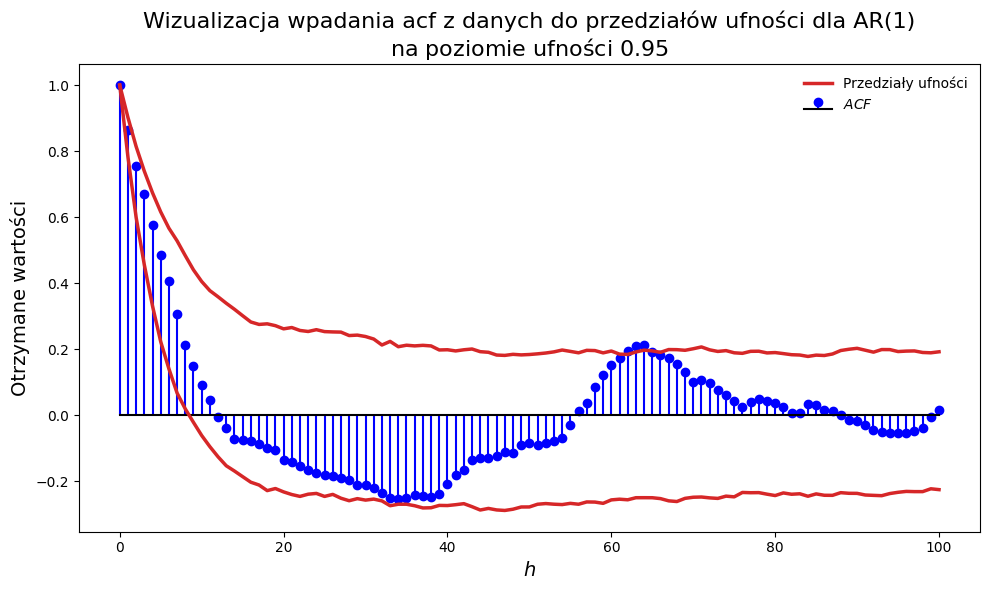

In [129]:
plt.figure(figsize=(10, 6)) 
# plt.scatter(np.arange(0, h + 1), est_ar_acf, label = "$ACF$")
plt.stem(np.arange(0, h + 1), est_ar_acf, "b", markerfmt = "bo", basefmt="black", label = "$ACF$")

plt.plot(np.arange(0, h + 1), acf_ar[0], c="C3", label = "Przedziały ufności", linewidth=2.5)
plt.plot(np.arange(0, h + 1), acf_ar[1], c="C3", linewidth=2.5)

plt.xlabel("$h$", fontsize=14)
plt.ylabel("Otrzymane wartości", fontsize=14)
plt.title("Wizualizacja wpadania acf z danych do przedziałów ufności dla AR(1)\nna poziomie ufności $0.95$", fontsize=16)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

C:\Users\aleks\AppData\Local\Temp\ipykernel_13116\599611624.py:3: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(np.arange(0, h + 1), est_ar_pacf, "b", markerfmt = "bo", basefmt="black", label = "$PACF$")


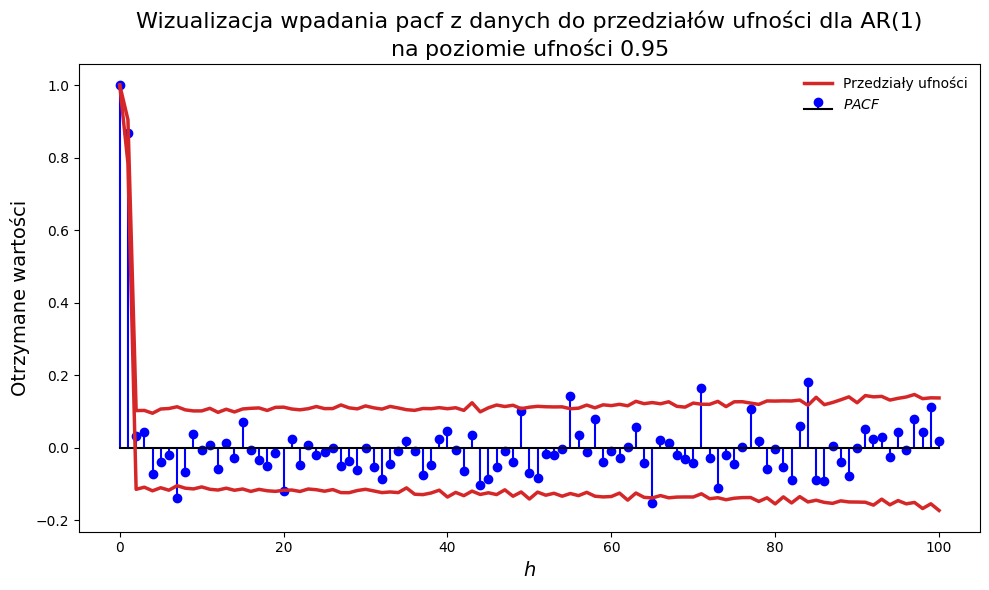

In [130]:
plt.figure(figsize=(10, 6)) 
# plt.scatter(np.arange(0, h + 1), est_ar_pacf, label = "$PACF$")
plt.stem(np.arange(0, h + 1), est_ar_pacf, "b", markerfmt = "bo", basefmt="black", label = "$PACF$")

plt.plot(np.arange(0, h + 1), pacf_ar[0], c="C3", label = "Przedziały ufności", linewidth=2.5)
plt.plot(np.arange(0, h + 1), pacf_ar[1], c="C3", linewidth=2.5)

plt.xlabel("$h$", fontsize=14)
plt.ylabel("Otrzymane wartości", fontsize=14)
plt.title("Wizualizacja wpadania pacf z danych do przedziałów ufności dla AR(1)\nna poziomie ufności $0.95$", fontsize=16)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

### **MODEL 2: MA(1)**

In [131]:
est_ma_acf = acf(final_open_2, nlags=h)
est_ma_pacf = pacf(final_open_2, nlags=h)

In [132]:
def func_MA_1(theta, sigma2, n, h, M, alph):
    est_acf = np.zeros((M, h + 1))
    est_pacf = np.zeros((M, h + 1))
    
    for i in range(M):
        X_t = MA_1(theta, sigma2, n)

        est_acf[i] = acf(X_t, nlags = h)
        est_pacf[i] = pacf(X_t, nlags = h)

    acf_up = np.zeros(h + 1)
    acf_down = np.zeros(h + 1)

    pacf_up = np.zeros(h + 1)
    pacf_down = np.zeros(h + 1)

    for k in range(h + 1):
        acf_up[k] = np.quantile(est_acf[:,k], 1 - (alph/2))
        acf_down[k] = np.quantile(est_acf[:,k], (alph/2))

        pacf_up[k] = np.quantile(est_pacf[:,k], 1 - (alph/2))
        pacf_down[k] = np.quantile(est_pacf[:,k], (alph/2))

    return [acf_up, acf_down], [pacf_up, pacf_down]

In [133]:
acf_ma, pacf_ma = func_MA_1(theta, sigma2_ar, len(final_date), h, M, alpha)

C:\Users\aleks\AppData\Local\Temp\ipykernel_13116\980601933.py:3: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(np.arange(0, h + 1), est_ma_acf, "b", markerfmt = "bo", basefmt="black", label = "$ACF$")


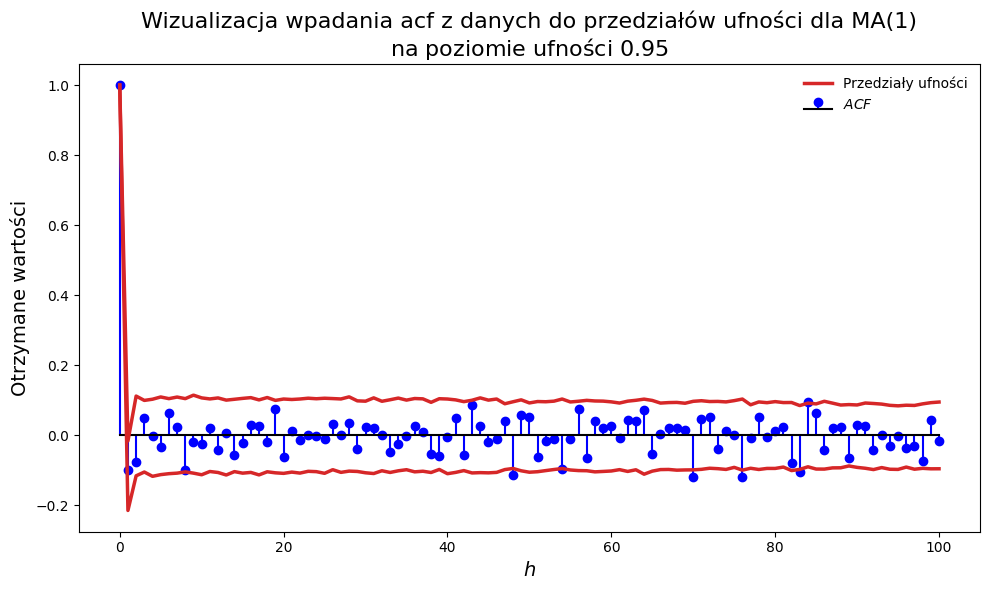

In [134]:
plt.figure(figsize=(10, 6)) 
# plt.scatter(np.arange(0, h + 1), est_ma_acf, label = "$ACF$")
plt.stem(np.arange(0, h + 1), est_ma_acf, "b", markerfmt = "bo", basefmt="black", label = "$ACF$")

plt.plot(np.arange(0, h + 1), acf_ma[0], c="C3", label = "Przedziały ufności", linewidth=2.5)
plt.plot(np.arange(0, h + 1), acf_ma[1], c="C3", linewidth=2.5)

# plt.stem(np.arange(0, h + 1), est_ma_acf, "b", markerfmt = "bo", basefmt="black", label = "$ACF$")
plt.xlabel("$h$", fontsize=14)
plt.ylabel("Otrzymane wartości", fontsize=14)
plt.title("Wizualizacja wpadania acf z danych do przedziałów ufności dla MA(1)\nna poziomie ufności $0.95$", fontsize=16)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

C:\Users\aleks\AppData\Local\Temp\ipykernel_13116\3248950609.py:3: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(np.arange(0, h + 1), est_ma_pacf, "b", markerfmt = "bo", basefmt="black", label = "$PACF$")


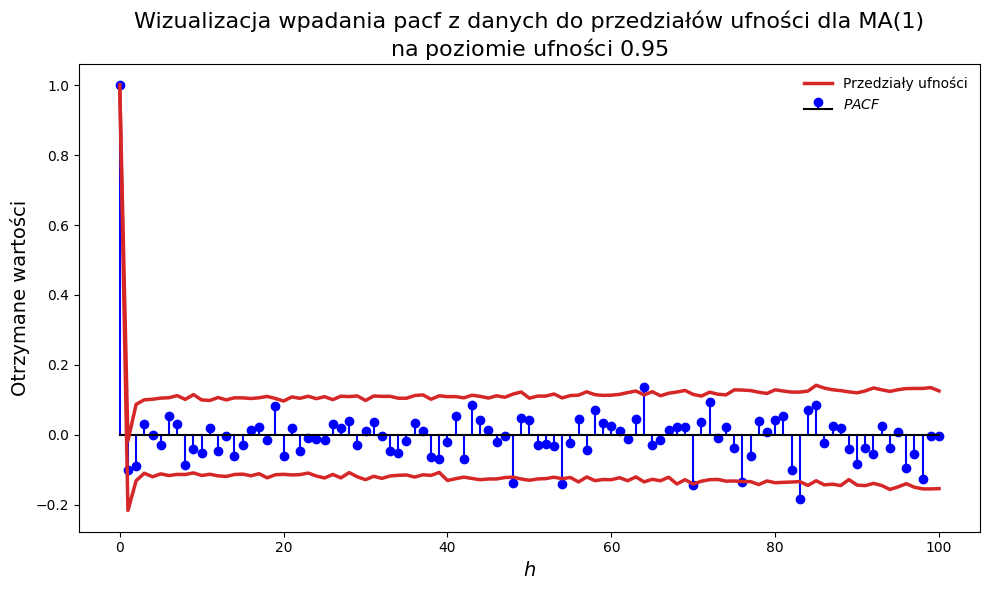

In [135]:
plt.figure(figsize=(10, 6)) 
# plt.scatter(np.arange(0, h + 1), est_ma_pacf, label = "$PACF$")
plt.stem(np.arange(0, h + 1), est_ma_pacf, "b", markerfmt = "bo", basefmt="black", label = "$PACF$")

plt.plot(np.arange(0, h + 1), pacf_ma[0], c="C3", label = "Przedziały ufności", linewidth=2.5)
plt.plot(np.arange(0, h + 1), pacf_ma[1], c="C3", linewidth=2.5)

plt.xlabel("$h$", fontsize=14)
plt.ylabel("Otrzymane wartości", fontsize=14)
plt.title("Wizualizacja wpadania pacf z danych do przedziałów ufności dla MA(1)\nna poziomie ufności $0.95$", fontsize=16)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

### **MODEL 2: ARMA(0, 0)**

In [136]:
def func_WN_1(sigma2, n, h, M, alph):
    est_acf = np.zeros((M, h + 1))
    est_pacf = np.zeros((M, h + 1))
    
    for i in range(M):
        X_t = np.random.normal(0, np.sqrt(sigma2), n)

        est_acf[i] = acf(X_t, nlags = h)
        est_pacf[i] = pacf(X_t, nlags = h)

    acf_up = np.zeros(h + 1)
    acf_down = np.zeros(h + 1)

    pacf_up = np.zeros(h + 1)
    pacf_down = np.zeros(h + 1)

    for k in range(h + 1):
        acf_up[k] = np.quantile(est_acf[:,k], 1 - (alph/2))
        acf_down[k] = np.quantile(est_acf[:,k], (alph/2))

        pacf_up[k] = np.quantile(est_pacf[:,k], 1 - (alph/2))
        pacf_down[k] = np.quantile(est_pacf[:,k], (alph/2))

    return [acf_up, acf_down], [pacf_up, pacf_down]

In [137]:
acf_wn, pacf_wn = func_WN_1(sigma2_ar, len(final_date), h, M, alpha)

C:\Users\aleks\AppData\Local\Temp\ipykernel_13116\2224941467.py:3: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(np.arange(0, h + 1), est_ma_acf, "b", markerfmt = "bo", basefmt="black", label = "$ACF$")


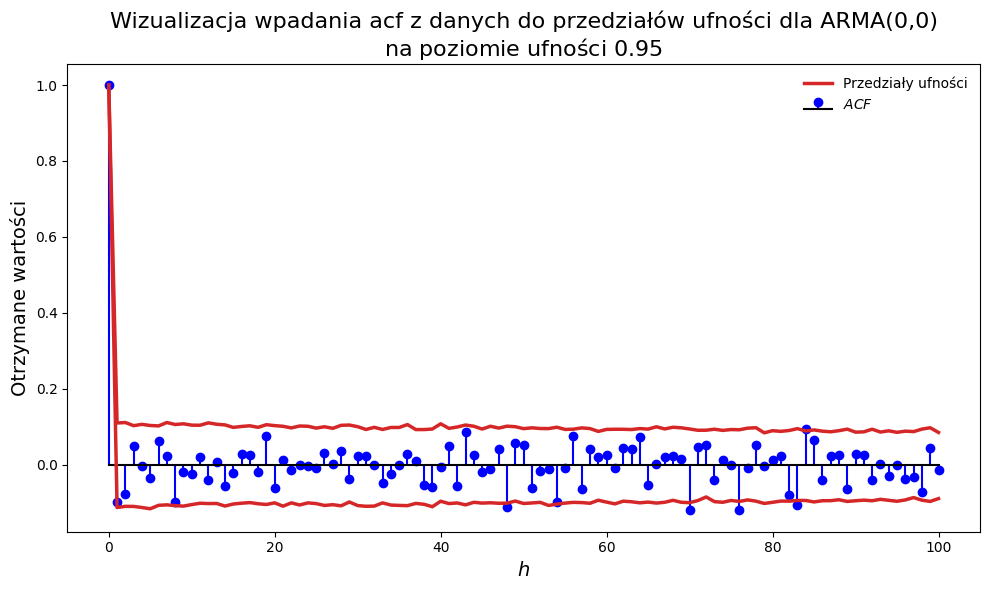

In [138]:
plt.figure(figsize=(10, 6)) 
# plt.scatter(np.arange(0, h + 1), est_ma_acf, label = "$ACF$")
plt.stem(np.arange(0, h + 1), est_ma_acf, "b", markerfmt = "bo", basefmt="black", label = "$ACF$")

plt.plot(np.arange(0, h + 1), acf_wn[0], c="C3", label = "Przedziały ufności", linewidth=2.5)
plt.plot(np.arange(0, h + 1), acf_wn[1], c="C3", linewidth=2.5)

plt.xlabel("$h$", fontsize=14)
plt.ylabel("Otrzymane wartości", fontsize=14)
plt.title("Wizualizacja wpadania acf z danych do przedziałów ufności dla ARMA(0,0)\nna poziomie ufności $0.95$", fontsize=16)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

C:\Users\aleks\AppData\Local\Temp\ipykernel_13116\94948128.py:3: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(np.arange(0, h + 1), est_ma_pacf, "b", markerfmt = "bo", basefmt="black", label = "$PACF$")


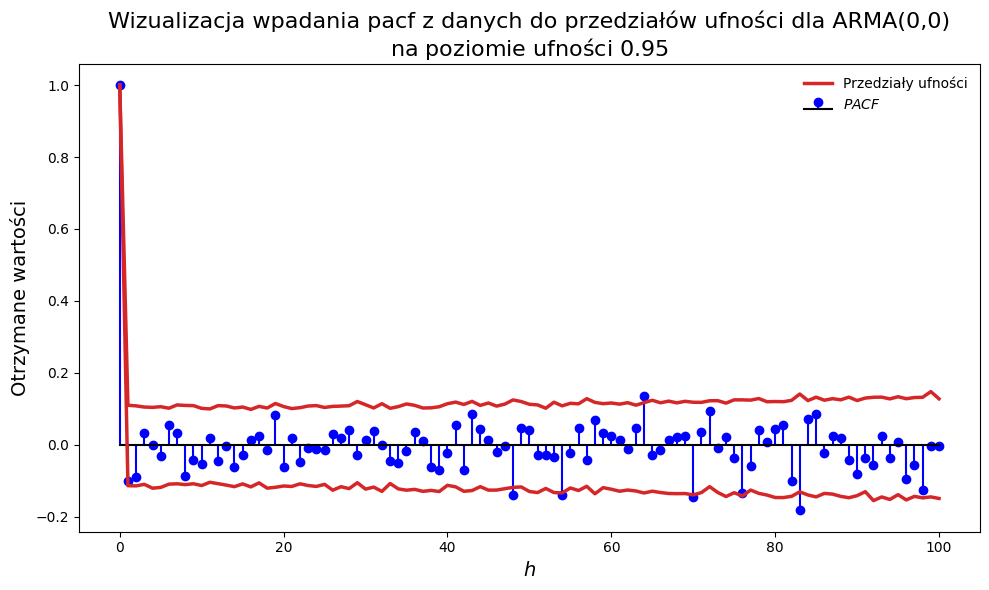

In [139]:
plt.figure(figsize=(10, 6)) 
# plt.scatter(np.arange(0, h + 1), est_ma_pacf, label = "$PACF$")
plt.stem(np.arange(0, h + 1), est_ma_pacf, "b", markerfmt = "bo", basefmt="black", label = "$PACF$")

plt.plot(np.arange(0, h + 1), pacf_wn[0], c="C3", label = "Przedziały ufności", linewidth=2.5)
plt.plot(np.arange(0, h + 1), pacf_wn[1], c="C3", linewidth=2.5)

plt.xlabel("$h$", fontsize=14)
plt.ylabel("Otrzymane wartości", fontsize=14)
plt.title("Wizualizacja wpadania pacf z danych do przedziałów ufności dla ARMA(0,0)\nna poziomie ufności $0.95$", fontsize=16)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

# - porównanie linii kwantylowych z trajektorią,


### **MODEL 1**

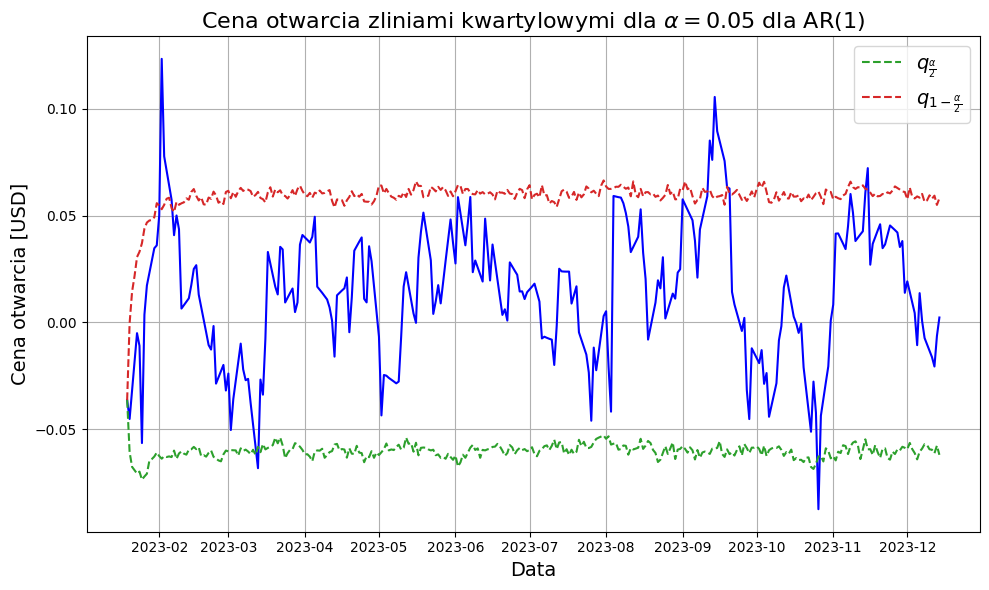

In [140]:
X_ts_ar = np.zeros((M, len(new_date)))
for i in range(M):
    X_ts_ar[i] = AR_1(sigma2_ar, phi, len(new_date))

q1_ar = np.zeros(len(new_date))
q2_ar = np.zeros(len(new_date))

for k in range(len(new_date)):
    q1_ar[k] = np.quantile(X_ts_ar[:, k], (alpha/2))
    q2_ar[k] = np.quantile(X_ts_ar[:, k], 1 - (alpha/2))


# Tworzenie wykresu
plt.figure(figsize=(10, 6)) 
plt.plot(new_date, final_open_1, c='b')
plt.plot(new_date, q1_ar, c='C2', linestyle='--', label='$q_{\\frac{\\alpha}{2}}$')
plt.plot(new_date, q2_ar, c='C3', linestyle='--', label='$q_{1 - \\frac{\\alpha}{2}}$')
plt.xlabel("Data", fontsize=14)
plt.ylabel("Cena otwarcia [USD]", fontsize=14)
plt.title("Cena otwarcia zliniami kwartylowymi dla $\\alpha = 0.05$ dla AR(1)", fontsize=16)
plt.legend(loc='upper right', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

### **MODEL 2**

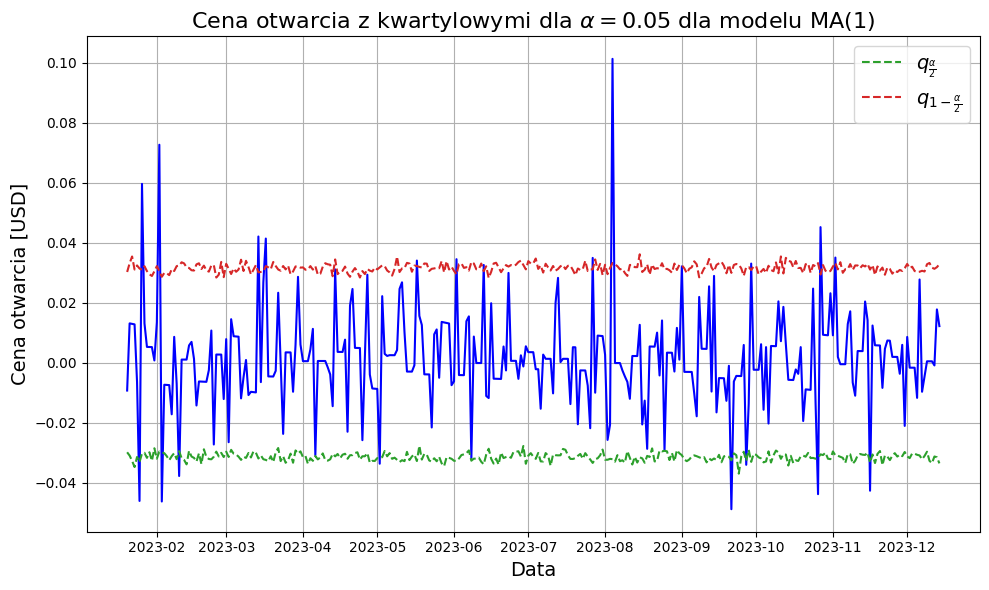

In [141]:
X_ts_ma = np.zeros((M, len(final_date)))
for i in range(M):
    X_ts_ma[i] = MA_1(theta, sigma2_ma, len(final_date))

q1_ma = np.zeros(len(final_date))
q2_ma = np.zeros(len(final_date))

for k in range(len(final_date)):
    q1_ma[k] = np.quantile(X_ts_ma[:,k], (alpha/2))
    q2_ma[k] = np.quantile(X_ts_ma[:,k], 1 - (alpha/2))


# Tworzenie wykresu
plt.figure(figsize=(10, 6)) 
plt.plot(final_date, final_open_2, c='b')
plt.plot(final_date, q1_ma, c='C2', linestyle='--', label='$q_{\\frac{\\alpha}{2}}$')
plt.plot(final_date, q2_ma, c='C3', linestyle='--', label='$q_{1 - \\frac{\\alpha}{2}}$')
plt.xlabel("Data", fontsize=14)
plt.ylabel("Cena otwarcia [USD]", fontsize=14)
plt.title("Cena otwarcia z kwartylowymi dla $\\alpha = 0.05$ dla modelu MA(1)", fontsize=16)
plt.legend(loc='upper right', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

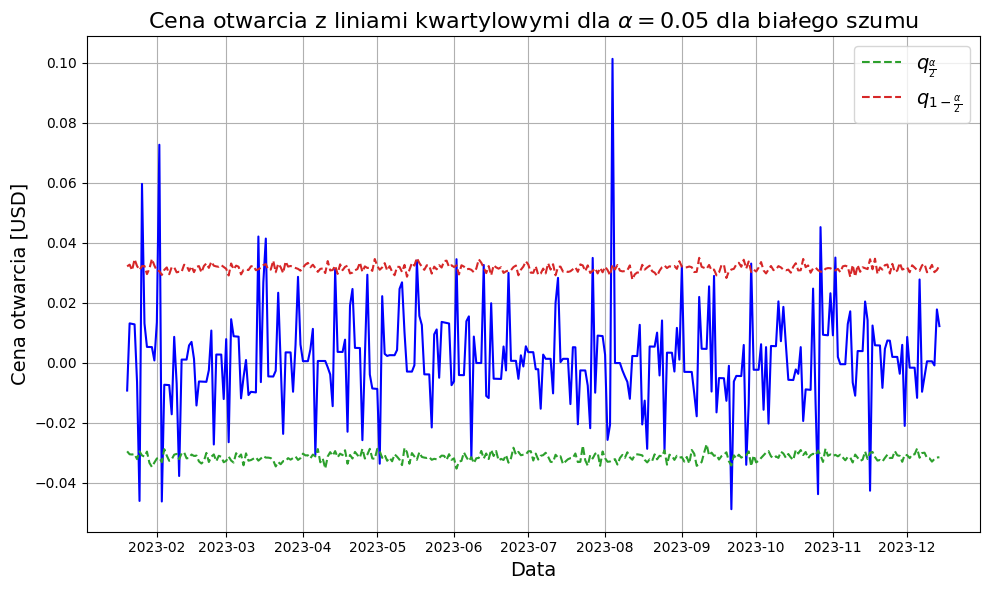

In [142]:
X_ts_wn = np.zeros((M, len(final_date)))
for i in range(M):
    X_ts_wn[i] = np.random.normal(0, np.sqrt(sigma2_wn), len(final_date))

q1_wn = np.zeros(len(final_date))
q2_wn = np.zeros(len(final_date))

for k in range(len(final_date)):
    q1_wn[k] = np.quantile(X_ts_wn[:,k], (alpha/2))
    q2_wn[k] = np.quantile(X_ts_wn[:,k], 1 - (alpha/2))


plt.figure(figsize=(10, 6)) 
plt.plot(final_date, final_open_2, c='b')
plt.plot(final_date, q1_wn, c='C2', linestyle='--', label='$q_{\\frac{\\alpha}{2}}$')
plt.plot(final_date, q2_wn, c='C3', linestyle='--', label='$q_{1 - \\frac{\\alpha}{2}}$')
plt.xlabel("Data", fontsize=14)
plt.ylabel("Cena otwarcia [USD]", fontsize=14)
plt.title("Cena otwarcia z liniami kwartylowymi dla $\\alpha = 0.05$ dla białego szumu", fontsize=16)
plt.legend(loc='upper right', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


# -  [OPCJONALNIE] prognoza dla przyszłych obserwacji i porównanie z rzeczywistymi danymi.

In [143]:
# Prognoza przyszłych wartości
forecast_1 = model_1.get_forecast(steps=len(predict_date))

# Pobranie prognoz i przedziałów ufności
forecast_values_1 = forecast_1.predicted_mean
confidence_intervals_1 = forecast_1.conf_int()

# Przekształcenie predykowanych wartości
x_p_1 = np.arange(len(final_open_1), len(final_open_1) + len(predict_date))
forecast_val_1 = np.exp(forecast_values_1 - func_sin(x_p_1, c, d, e) + poly_fit(x_p_1)) # plus sin nie dziala wtf

# Przekształcenie przedziałów ufności
interval_down_1 = np.exp(confidence_intervals_1[:, 0] - func_sin(x_p_1, c, d, e) + poly_fit(x_p_1))
interval_up_1 = np.exp(confidence_intervals_1[:, 1] - func_sin(x_p_1, c, d, e) + poly_fit(x_p_1))

In [144]:
# Prognoza przyszłych wartości
forecast_2 = model_2.get_forecast(steps=len(predict_date))

# Pobranie prognoz i przedziałów ufności
forecast_values_2 = forecast_2.predicted_mean
confidence_intervals_2 = forecast_2.conf_int()

# Przekształcenie predykowanych wartości
forecast_val_2 = np.exp(np.cumsum(np.concatenate(([log_open[-1]], forecast_values_2))))
forecast_val_2 = forecast_val_2[:-1]

# Przekształcenie przedziałów ufności
interval_down_2 = np.exp(np.cumsum(np.concatenate(([log_open[-1]], confidence_intervals_2[:, 0]))))
interval_up_2 = np.exp(np.cumsum(np.concatenate(([log_open[-1]], confidence_intervals_2[:, 1]))))

interval_down_2 = interval_down_2[:-1]
interval_up_2 = interval_up_2[:-1]

In [145]:
# Prognoza przyszłych wartości
forecast_2_2 = model_2_2.get_forecast(steps=len(predict_date))

# Pobranie prognoz i przedziałów ufności
forecast_values_2_2 = forecast_2_2.predicted_mean
confidence_intervals_2_2 = forecast_2_2.conf_int()

# Przekształcenie predykowanych wartości
forecast_val_2_2 = np.exp(np.cumsum(np.concatenate(([log_open[-1]], forecast_values_2_2))))
forecast_val_2_2 = forecast_val_2_2[:-1]

# Przekształcenie przedziałów ufności
interval_down_2_2 = np.exp(np.cumsum(np.concatenate(([log_open[-1]], confidence_intervals_2_2[:, 0]))))
interval_up_2_2 = np.exp(np.cumsum(np.concatenate(([log_open[-1]], confidence_intervals_2_2[:, 1]))))

interval_down_2_2 = interval_down_2_2[:-1]
interval_up_2_2 = interval_up_2_2[:-1]

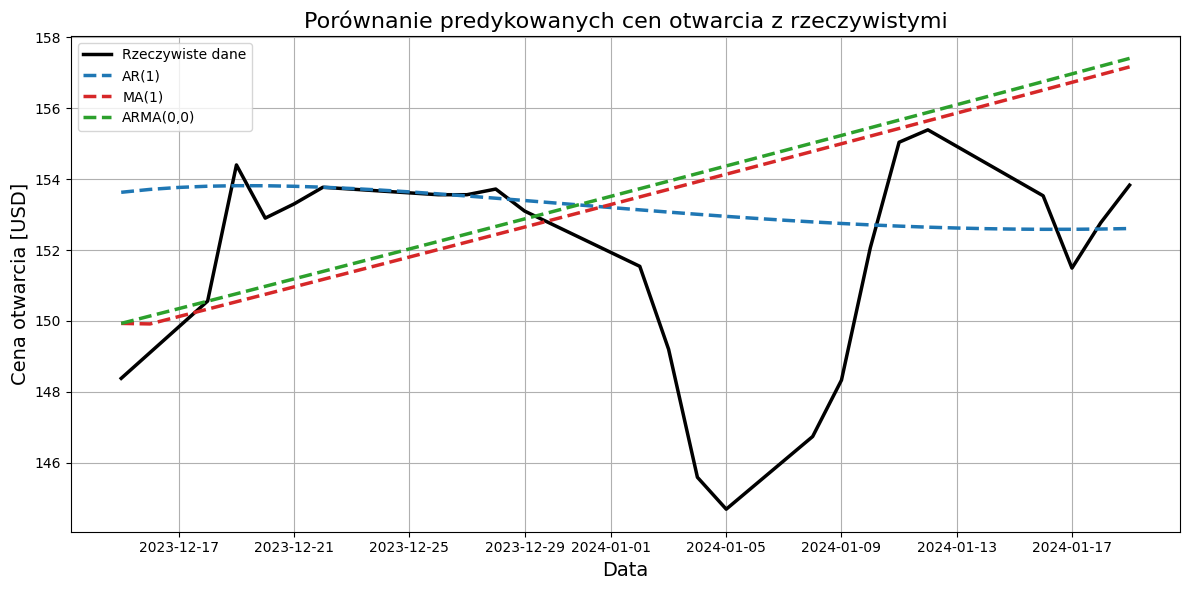

In [146]:
# Tworzenie wykresu
plt.figure(figsize=(12, 6)) 
plt.plot(predict_date, predict_open, c='black', label = 'Rzeczywiste dane', linewidth = 2.5)
plt.plot(predict_date, forecast_val_1, c='C0', linestyle='--', label='AR(1)', linewidth = 2.5)
plt.plot(predict_date, forecast_val_2, c='C3', linestyle='--', label='MA(1)', linewidth = 2.5)
plt.plot(predict_date, forecast_val_2_2, c='C2', linestyle='--', label='ARMA(0,0)', linewidth = 2.5)
plt.xlabel("Data", fontsize=14)
plt.ylabel("Cena otwarcia [USD]", fontsize=14)
plt.title("Porównanie predykowanych cen otwarcia z rzeczywistymi", fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

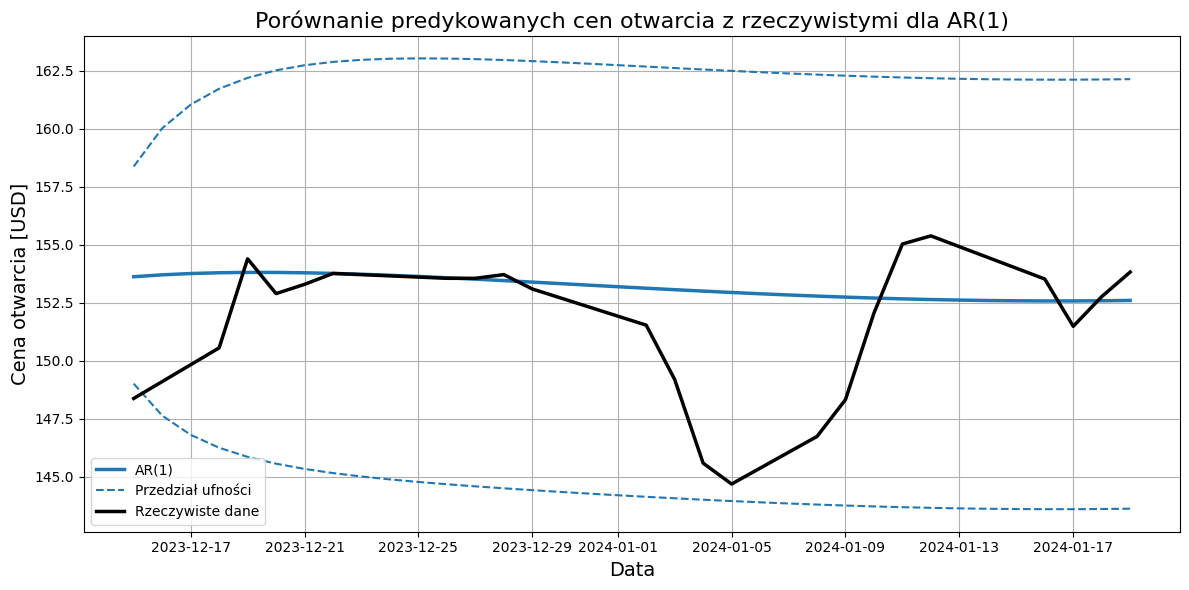

In [147]:
# Tworzenie wykresu
plt.figure(figsize=(12, 6)) 
plt.plot(predict_date, forecast_val_1, c='C0', label='AR(1)', linewidth = 2.5)
plt.plot(predict_date, interval_up_1, c='C0', linestyle='--', label = "Przedział ufności")
plt.plot(predict_date, interval_down_1, c='C0', linestyle='--')
plt.plot(predict_date, predict_open, c='black', label = 'Rzeczywiste dane', linewidth = 2.5)
plt.xlabel("Data", fontsize=14)
plt.ylabel("Cena otwarcia [USD]", fontsize=14)
plt.title("Porównanie predykowanych cen otwarcia z rzeczywistymi dla AR(1)", fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

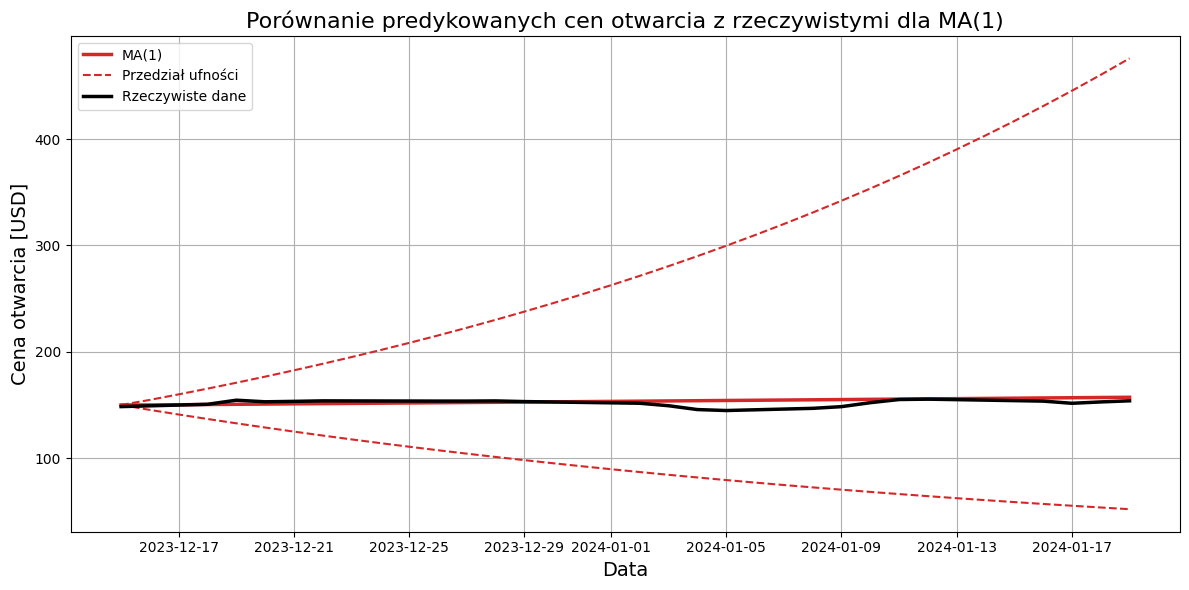

In [148]:
# Tworzenie wykresu
plt.figure(figsize=(12, 6)) 
plt.plot(predict_date, forecast_val_2, c='C3', label='MA(1)', linewidth = 2.5)
plt.plot(predict_date, interval_up_2, c='C3', linestyle='--', label = "Przedział ufności")
plt.plot(predict_date, interval_down_2, c='C3', linestyle='--')
plt.plot(predict_date, predict_open, c='black', label = 'Rzeczywiste dane', linewidth = 2.5)
plt.xlabel("Data", fontsize=14)
plt.ylabel("Cena otwarcia [USD]", fontsize=14)
plt.title("Porównanie predykowanych cen otwarcia z rzeczywistymi dla MA(1)", fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

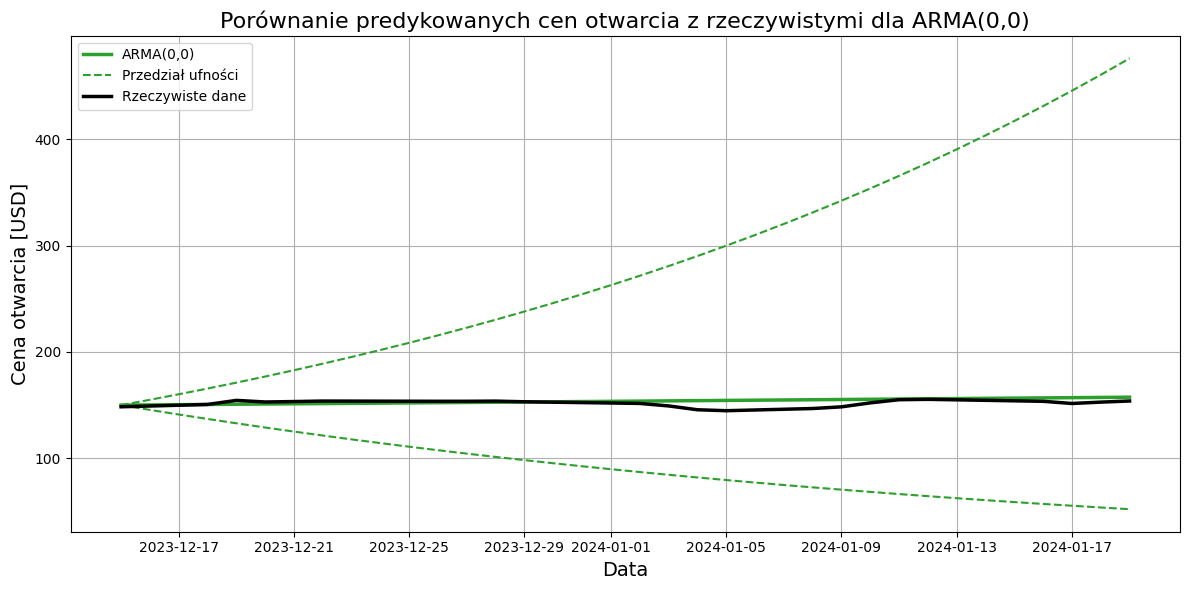

In [149]:
# Tworzenie wykresu
plt.figure(figsize=(12, 6)) 
plt.plot(predict_date, forecast_val_2_2, c='C2', label='ARMA(0,0)', linewidth = 2.5)
plt.plot(predict_date, interval_up_2_2, c='C2', linestyle='--', label = "Przedział ufności")
plt.plot(predict_date, interval_down_2_2, c='C2', linestyle='--')
plt.plot(predict_date, predict_open, c='black', label = 'Rzeczywiste dane', linewidth = 2.5)
plt.xlabel("Data", fontsize=14)
plt.ylabel("Cena otwarcia [USD]", fontsize=14)
plt.title("Porównanie predykowanych cen otwarcia z rzeczywistymi dla ARMA(0,0)", fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# **4. Weryfikacja założeń dotyczących szumu**


# -  założenie dot. średniej (wykres wartości resztowych / t test),
#  - założenie dot. wariancji (wykres wartości resztowych / Modified Levene Test / Arch Test),


raczej wszystko wyszlo jak powinno

### residua zwykłe

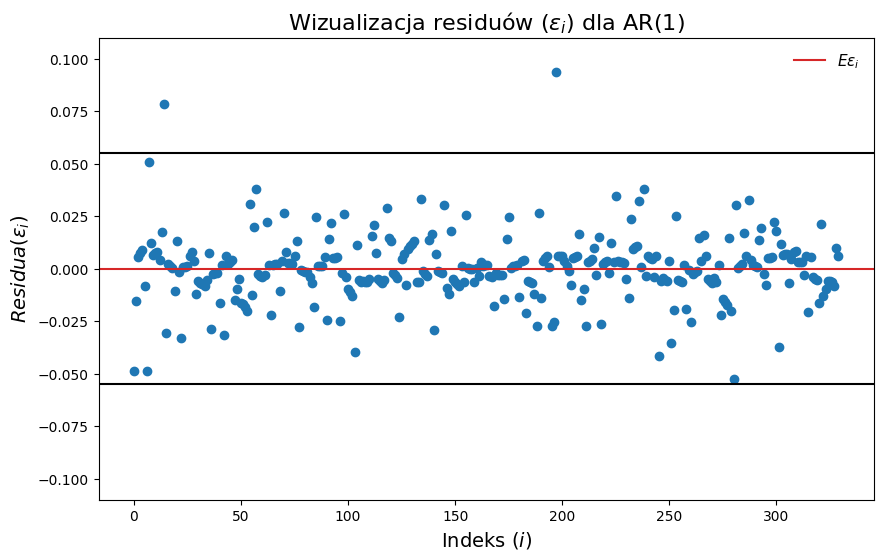

In [150]:
plt.figure(figsize=(10, 6))
plt.scatter(range(len(residuals_1)), residuals_1)
plt.axhline(0, c="C3", label = "$E\epsilon_{i}$") # tutaj wiariancja jest w miare stała
plt.axhline(0.055, c="black")
plt.axhline(-0.055, c="black")
plt.ylim(-0.11, 0.11)
plt.ylabel("$Residua (\epsilon_{i})$", fontsize=14) 
plt.xlabel("Indeks ($i$)", fontsize=14) 
plt.title("Wizualizacja residuów ($\epsilon_{i}$) dla AR(1)", fontsize=16)
plt.legend(frameon=False, fontsize=11)
plt.show()

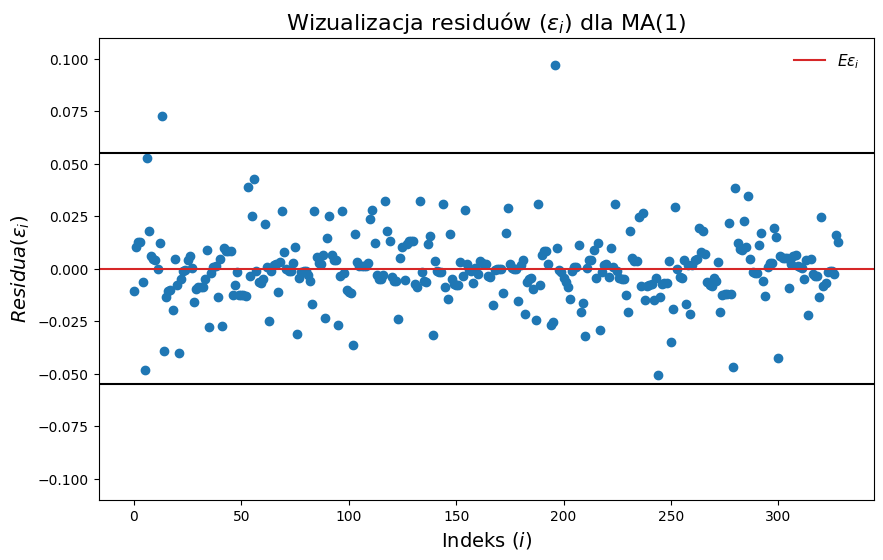

In [151]:
plt.figure(figsize=(10, 6))
plt.scatter(range(len(residuals_2)), residuals_2)
plt.axhline(0, c="C3", label = "$E\epsilon_{i}$") # tutaj wiariancja jest w miare stała 
plt.axhline(0.055, c="black")
plt.axhline(-0.055, c="black")
plt.ylim(-0.11, 0.11)
plt.ylabel("$Residua (\epsilon_{i})$", fontsize=14) 
plt.xlabel("Indeks ($i$)", fontsize=14) 
plt.title("Wizualizacja residuów ($\epsilon_{i}$) dla MA(1)", fontsize=16)
plt.legend(frameon=False, fontsize=11)
plt.show()

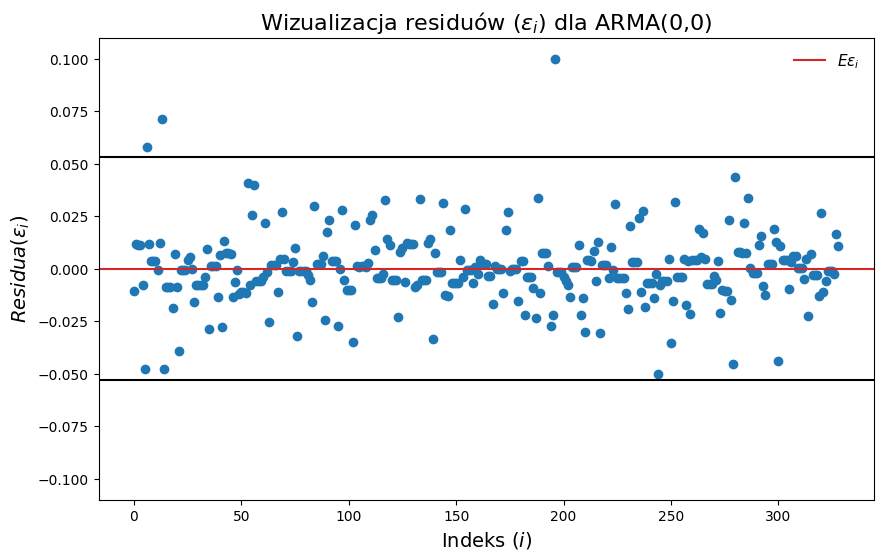

In [152]:
plt.figure(figsize=(10, 6))
plt.scatter(range(len(residuals_2_2)), residuals_2_2)
plt.axhline(0, c="C3", label = "$E\epsilon_{i}$") # tutaj wiariancja jest w miare stała \
plt.axhline(0.053, c="black")
plt.axhline(-0.053, c="black")
plt.ylim(-0.11, 0.11)
plt.ylabel("$Residua (\epsilon_{i})$", fontsize=14) 
plt.xlabel("Indeks ($i$)", fontsize=14) 
plt.title("Wizualizacja residuów ($\epsilon_{i}$) dla ARMA(0,0)", fontsize=16)
plt.legend(frameon=False, fontsize=11)
plt.show()

# -  założenie dot. niezależności (wykres ACF/PACF dla wartości resztowych / test Ljunga-Boxa),

C:\Users\aleks\AppData\Local\Temp\ipykernel_13116\1172216934.py:4: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(np.arange(0, h + 1), acf_residuals_1, "r", markerfmt = "ro", basefmt='black')


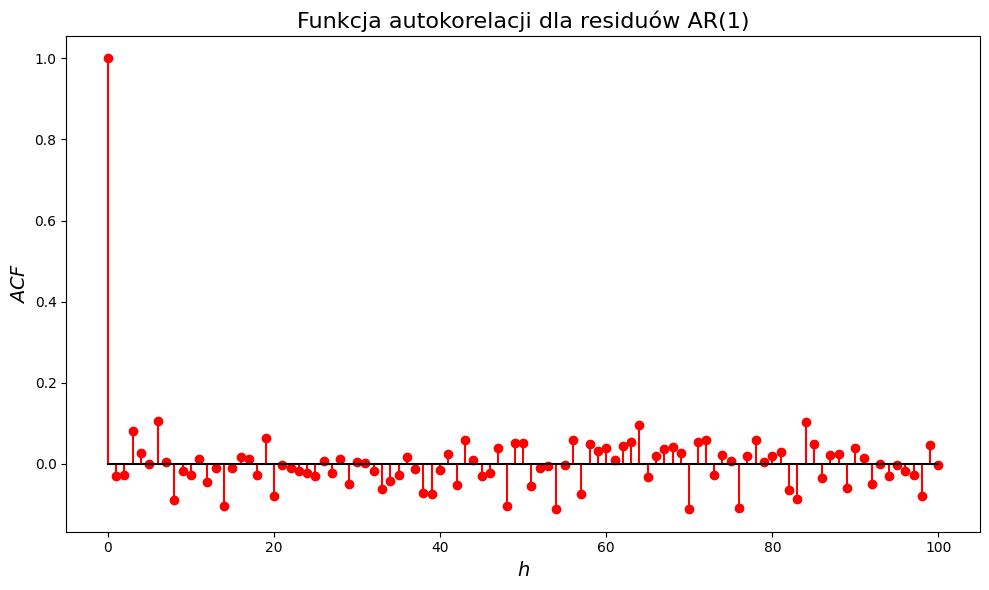

In [153]:
acf_residuals_1 = acf(residuals_1, nlags=h)

plt.figure(figsize=(10, 6))
plt.stem(np.arange(0, h + 1), acf_residuals_1, "r", markerfmt = "ro", basefmt='black')
plt.title("Funkcja autokorelacji dla residuów AR(1)", fontsize=16)
plt.xlabel("$h$", fontsize=14)
plt.ylabel("$ACF$", fontsize=14)
plt.tight_layout()
plt.show()

C:\Users\aleks\AppData\Local\Temp\ipykernel_13116\1671707455.py:4: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(np.arange(0, h + 1), pacf_residuals_1, "r", markerfmt = "ro", basefmt='black')


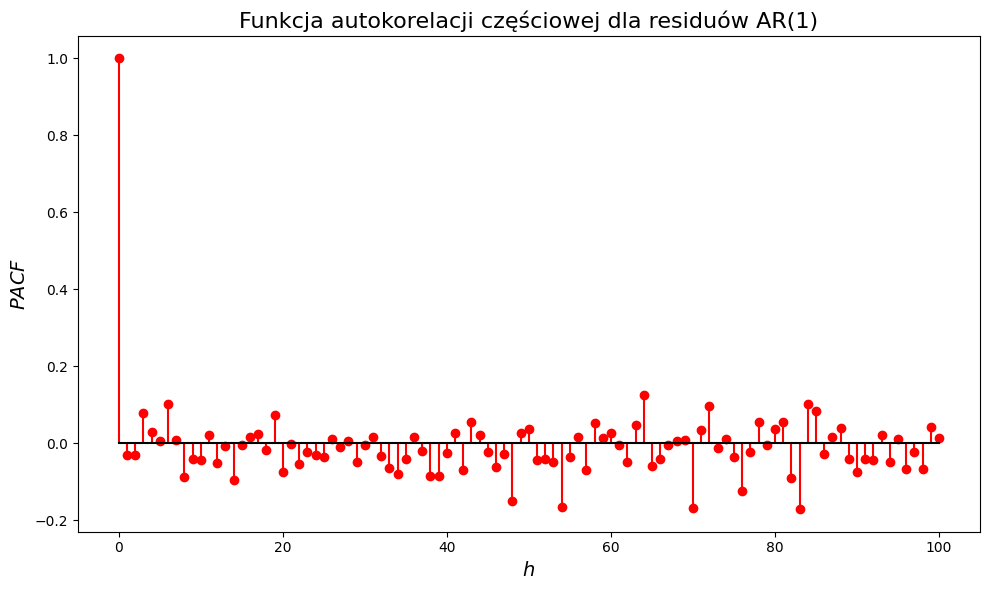

In [154]:
pacf_residuals_1 = pacf(residuals_1, nlags=h)

plt.figure(figsize=(10, 6))
plt.stem(np.arange(0, h + 1), pacf_residuals_1, "r", markerfmt = "ro", basefmt='black')
plt.title("Funkcja autokorelacji częściowej dla residuów AR(1)", fontsize=16)
plt.xlabel("$h$", fontsize=14)
plt.ylabel("$PACF$", fontsize=14)
plt.tight_layout()
plt.show()

C:\Users\aleks\AppData\Local\Temp\ipykernel_13116\3103801930.py:4: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(np.arange(0, h + 1), acf_residuals_2, "r", markerfmt = "ro", basefmt='black')


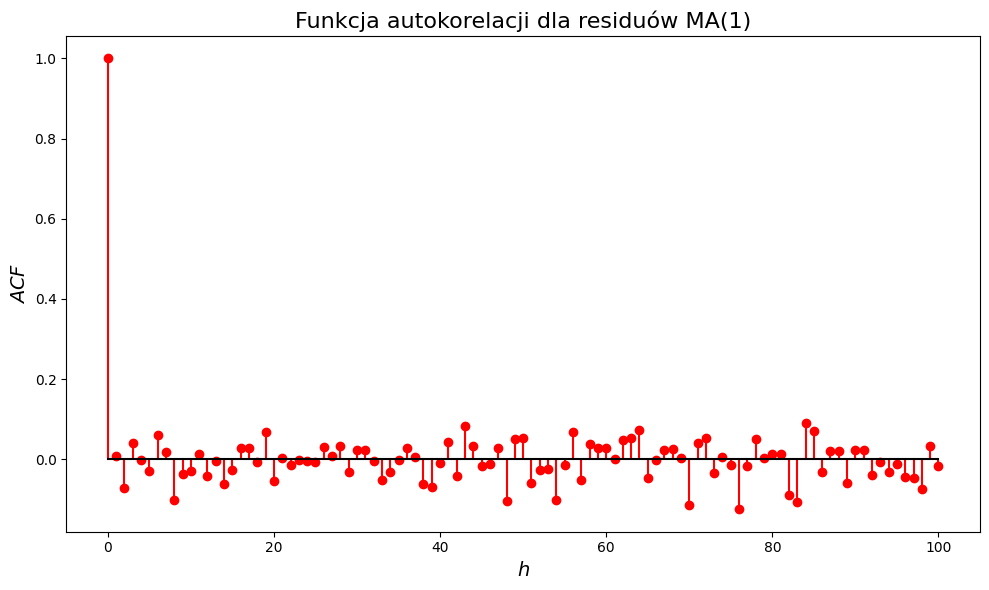

In [155]:
acf_residuals_2 = acf(residuals_2, nlags=h)

plt.figure(figsize=(10, 6))
plt.stem(np.arange(0, h + 1), acf_residuals_2, "r", markerfmt = "ro", basefmt='black')
plt.title("Funkcja autokorelacji dla residuów MA(1)", fontsize=16)
plt.xlabel("$h$", fontsize=14)
plt.ylabel("$ACF$", fontsize=14)
plt.tight_layout()
plt.show()

C:\Users\aleks\AppData\Local\Temp\ipykernel_13116\55624164.py:4: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(np.arange(0, h + 1), pacf_residuals_2, "r", markerfmt = "ro", basefmt='black')


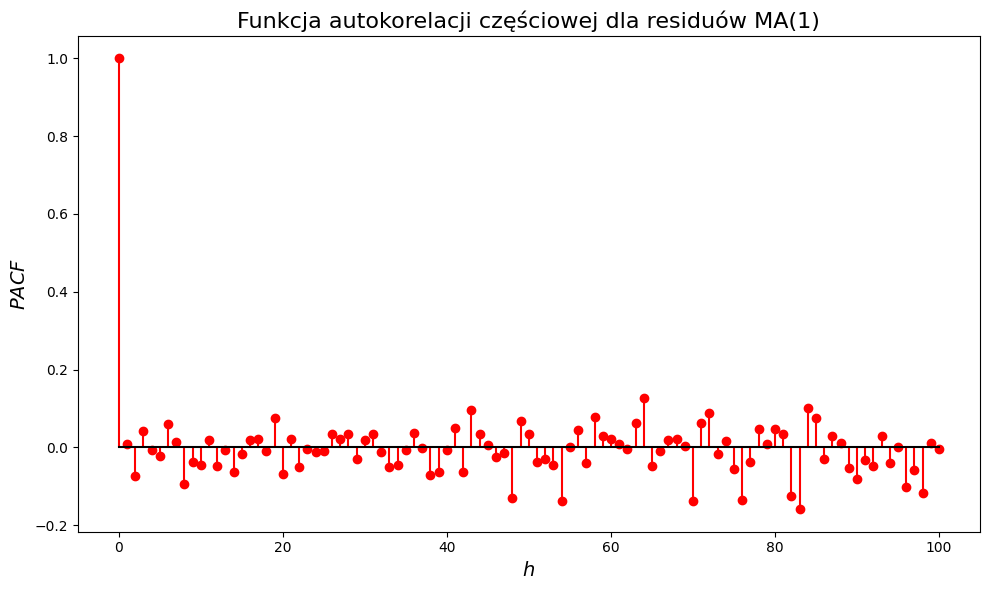

In [156]:
pacf_residuals_2 = pacf(residuals_2, nlags=h)

plt.figure(figsize=(10, 6))
plt.stem(np.arange(0, h + 1), pacf_residuals_2, "r", markerfmt = "ro", basefmt='black')
plt.title("Funkcja autokorelacji częściowej dla residuów MA(1)", fontsize=16)
plt.xlabel("$h$", fontsize=14)
plt.ylabel("$PACF$", fontsize=14)
plt.tight_layout()
plt.show()

C:\Users\aleks\AppData\Local\Temp\ipykernel_13116\2837072210.py:4: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(np.arange(0, h + 1), acf_residuals_2_2, "r", markerfmt = "ro", basefmt='black')


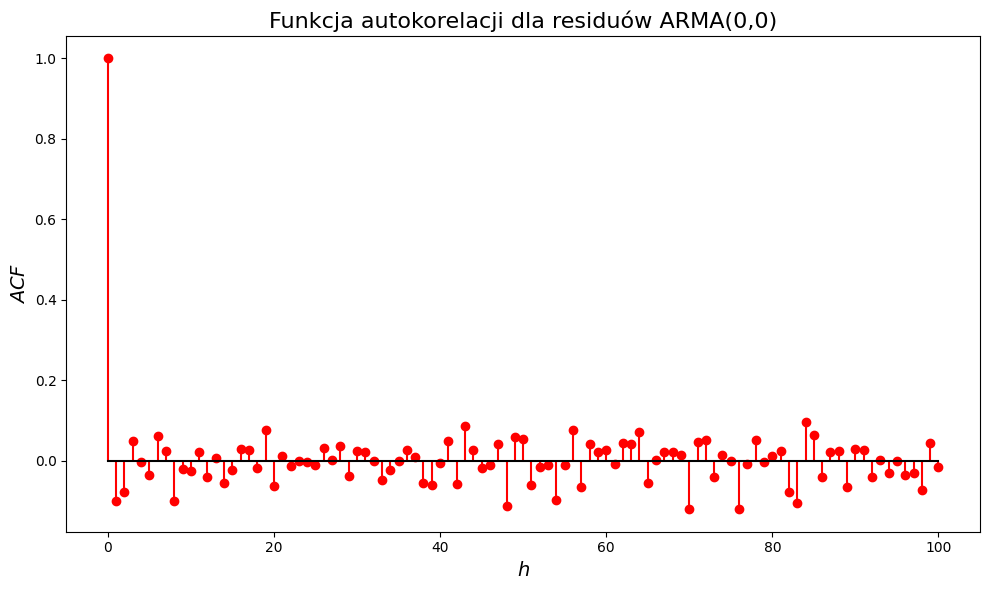

In [157]:
acf_residuals_2_2 = acf(residuals_2_2, nlags=h)

plt.figure(figsize=(10, 6))
plt.stem(np.arange(0, h + 1), acf_residuals_2_2, "r", markerfmt = "ro", basefmt='black')
plt.title("Funkcja autokorelacji dla residuów ARMA(0,0)", fontsize=16)
plt.xlabel("$h$", fontsize=14)
plt.ylabel("$ACF$", fontsize=14)
plt.tight_layout()
plt.show()

C:\Users\aleks\AppData\Local\Temp\ipykernel_13116\2559047062.py:4: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(np.arange(0, h + 1), pacf_residuals_2_2, "r", markerfmt = "ro", basefmt='black')


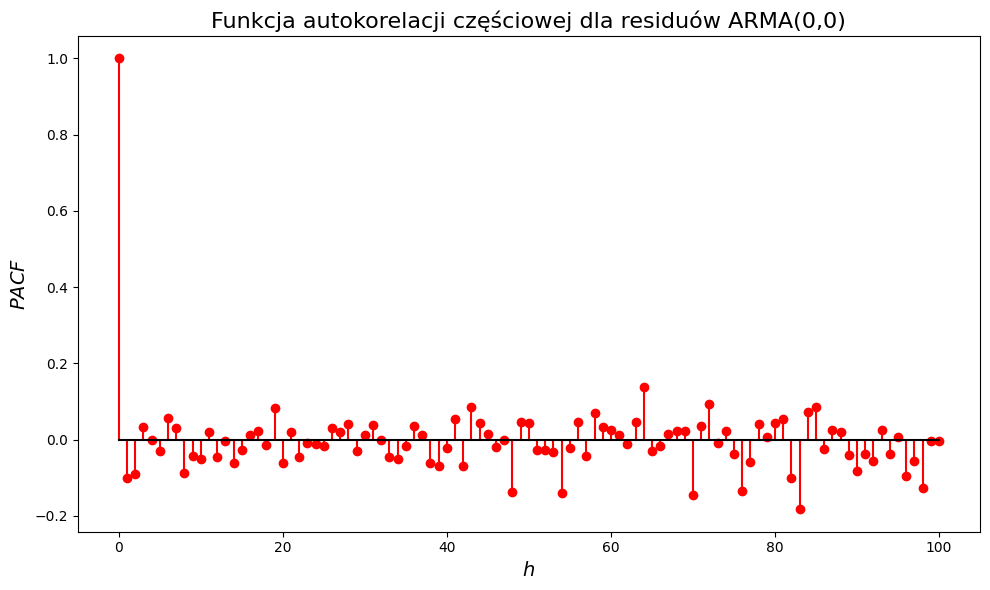

In [158]:
pacf_residuals_2_2 = pacf(residuals_2_2, nlags=h)

plt.figure(figsize=(10, 6))
plt.stem(np.arange(0, h + 1), pacf_residuals_2_2, "r", markerfmt = "ro", basefmt='black')
plt.title("Funkcja autokorelacji częściowej dla residuów ARMA(0,0)", fontsize=16)
plt.xlabel("$h$", fontsize=14)
plt.ylabel("$PACF$", fontsize=14)
plt.tight_layout()
plt.show()

# założenie dot. normalności rozkładu (dystrybuanta / gęstość / wykres kwantylowy / testy na normalność).

# testy...

## AR(1)

In [159]:
print("Test kołmogorowa-Smirnowa:   " +  str(stats.kstest((residuals_1 - np.mean(residuals_1))/np.sqrt(sigma2_ar), "norm")))
print("Test Shapiro_Wilka:   " +  str(stats.shapiro(residuals_1))) 
print("Test Jarque-Bera:   " + str(stats.jarque_bera(residuals_1)))

Test kołmogorowa-Smirnowa:   KstestResult(statistic=0.11808881132199678, pvalue=0.0001818978542013389)
Test Shapiro_Wilka:   ShapiroResult(statistic=0.9176558256149292, pvalue=1.7670733582983433e-12)
Test Jarque-Bera:   Jarque_beraResult(statistic=506.16026790582697, pvalue=0.0)


## MA(1)

In [160]:
print("Test kołmogorowa-Smirnowa:   " +  str(stats.kstest((residuals_2 - np.mean(residuals_2))/np.sqrt(sigma2_ma), "norm")))
print("Test Shapiro_Wilka:   " +  str(stats.shapiro(residuals_2))) 
print("Test Jarque-Bera:   " + str(stats.jarque_bera(residuals_2)))

Test kołmogorowa-Smirnowa:   KstestResult(statistic=0.11244646972427252, pvalue=0.0004439243504836053)
Test Shapiro_Wilka:   ShapiroResult(statistic=0.9234809875488281, pvalue=6.250085084896773e-12)
Test Jarque-Bera:   Jarque_beraResult(statistic=453.9116554783032, pvalue=0.0)


## ARMA(0,0)

In [161]:
print("Test kołmogorowa-Smirnowa:   " +  str(stats.kstest((residuals_2_2 - np.mean(residuals_2_2))/np.sqrt(sigma2_wn), "norm")))
print("Test Shapiro_Wilka:   " +  str(stats.shapiro(residuals_2_2))) 
print("Test Jarque-Bera:   " + str(stats.jarque_bera(residuals_2_2)))

Test kołmogorowa-Smirnowa:   KstestResult(statistic=0.1297753190714903, pvalue=2.726547649977611e-05)
Test Shapiro_Wilka:   ShapiroResult(statistic=0.9107053279876709, pvalue=4.722958677795541e-13)
Test Jarque-Bera:   Jarque_beraResult(statistic=546.5570045482766, pvalue=0.0)


# dystrybuanty

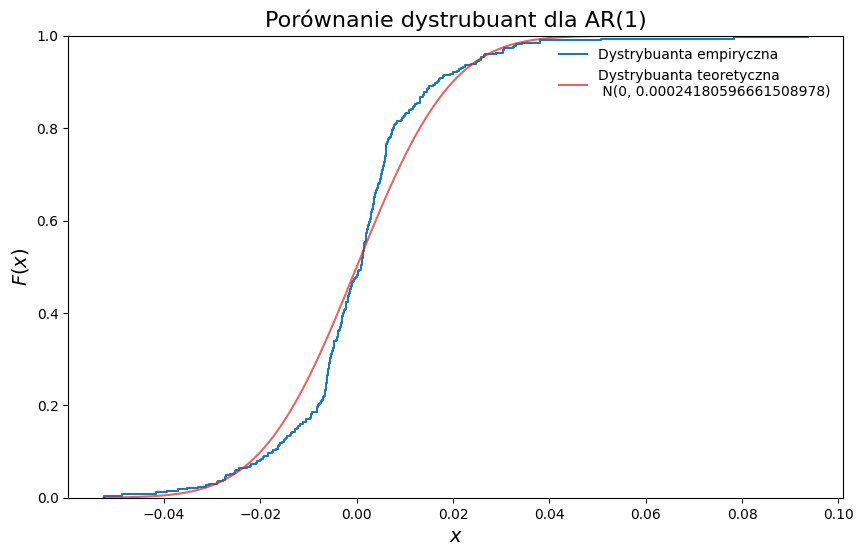

In [162]:
plt.figure(figsize=(10, 6))
sns.ecdfplot(data = residuals_1, label = "Dystrybuanta empiryczna")

t = np.linspace(np.min(residuals_1), np.max(residuals_1), 1000)
th_F = stats.norm.cdf(t, 0, np.sqrt(sigma2_ar))
plt.plot(t, th_F, label = f"Dystrybuanta teoretyczna\n N(0, {sigma2_ar})", alpha = 0.7, color = "C3")

plt.title("Porównanie dystrubuant dla AR(1)", fontsize=16)
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$F(x)$", fontsize=14)
plt.legend(frameon=False)
plt.show()

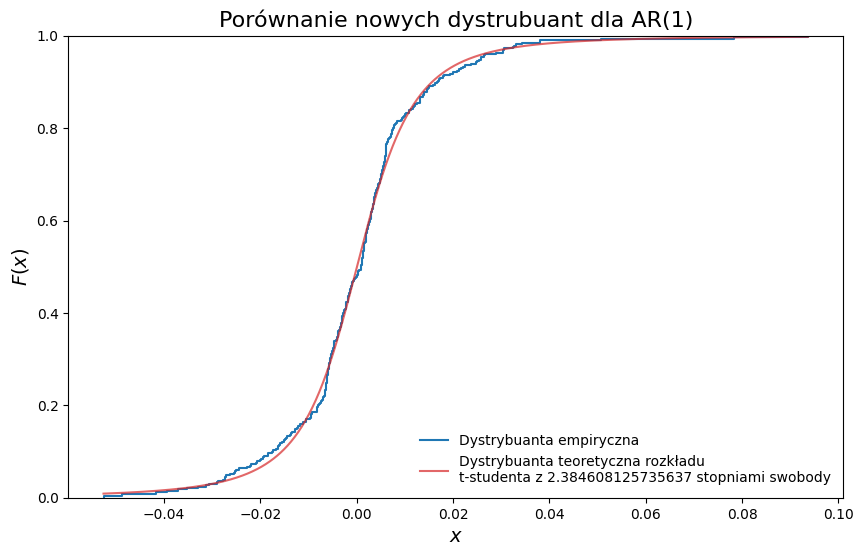

In [163]:
plt.figure(figsize=(10, 6))
sns.ecdfplot(data = residuals_1, label = "Dystrybuanta empiryczna")

t = np.linspace(np.min(residuals_1), np.max(residuals_1), 1000)
params_1 = stats.t.fit(residuals_1)
th_F = stats.t.cdf(t,  params_1[0],params_1[1], params_1[2])
plt.plot(t, th_F, label = f"Dystrybuanta teoretyczna rozkładu\nt-studenta z {params_1[0]} stopniami swobody", alpha = 0.7, color = "C3")

plt.title("Porównanie nowych dystrubuant dla AR(1)", fontsize=16)
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$F(x)$", fontsize=14)
plt.legend(frameon=False)
plt.show()

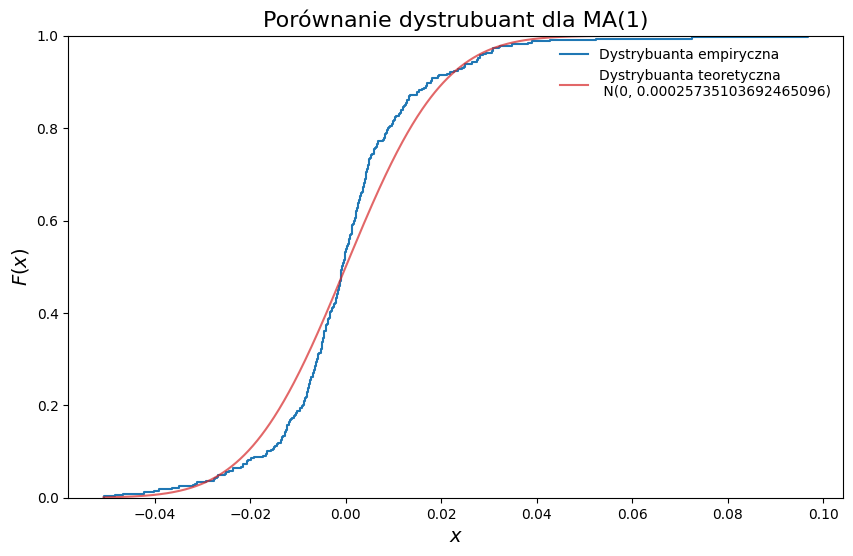

In [164]:
plt.figure(figsize=(10, 6))
sns.ecdfplot(data = residuals_2, label = "Dystrybuanta empiryczna")

t = np.linspace(np.min(residuals_2), np.max(residuals_2), 1000)
th_F = stats.norm.cdf(t, 0, np.sqrt(sigma2_ma))
plt.plot(t, th_F, label = f"Dystrybuanta teoretyczna\n N(0, {sigma2_ma})", alpha = 0.7, color = "C3")

plt.title("Porównanie dystrubuant dla MA(1)", fontsize=16)
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$F(x)$", fontsize=14)
plt.legend(frameon=False)
plt.show()

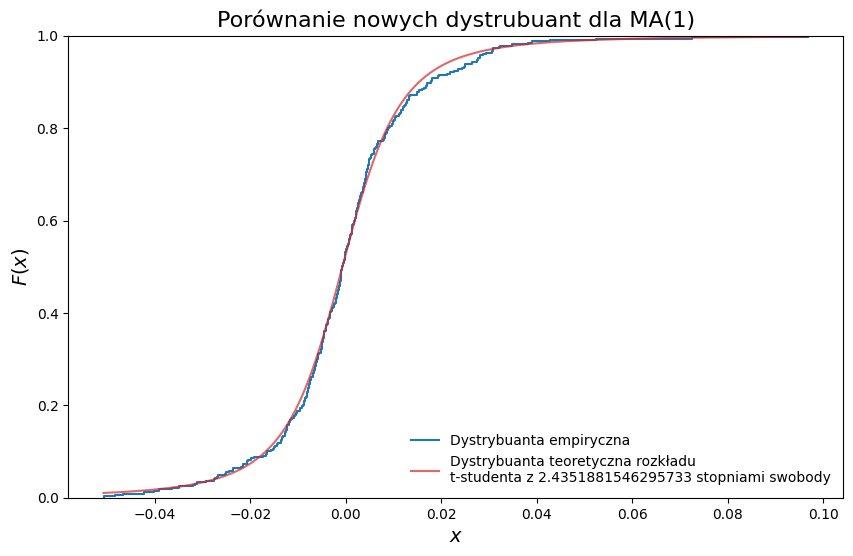

In [165]:
plt.figure(figsize=(10, 6))
sns.ecdfplot(data = residuals_2, label = "Dystrybuanta empiryczna")

t = np.linspace(np.min(residuals_2), np.max(residuals_2), 1000)
params_2 = stats.t.fit(residuals_2)
th_F = stats.t.cdf(t,  params_2[0],params_2[1], params_2[2])
plt.plot(t, th_F, label = f"Dystrybuanta teoretyczna rozkładu\nt-studenta z {params_2[0]} stopniami swobody", alpha = 0.7, color = "C3")

plt.title("Porównanie nowych dystrubuant dla MA(1)", fontsize=16)
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$F(x)$", fontsize=14)
plt.legend(frameon=False)
plt.show()

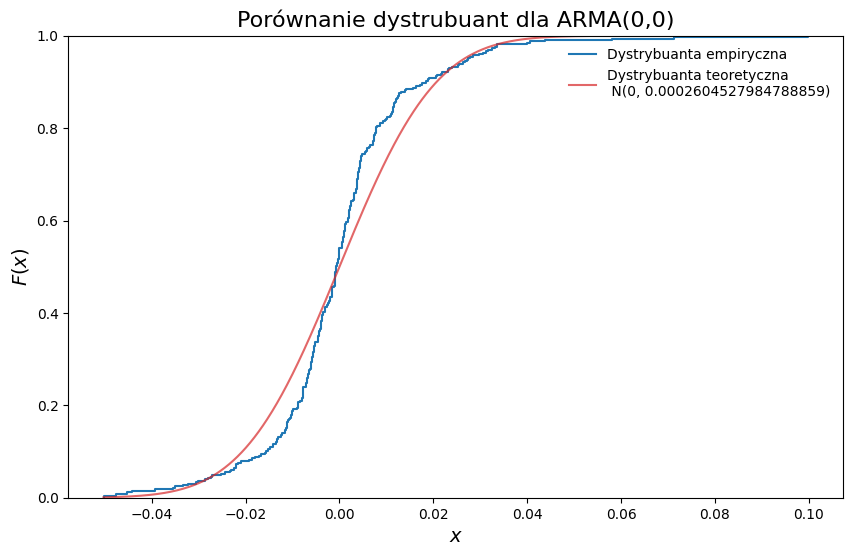

In [166]:
plt.figure(figsize=(10, 6))
sns.ecdfplot(data = residuals_2_2, label = "Dystrybuanta empiryczna")

t = np.linspace(np.min(residuals_2_2), np.max(residuals_2_2), 1000)
th_F = stats.norm.cdf(t, 0, np.sqrt(sigma2_wn))
plt.plot(t, th_F, label = f"Dystrybuanta teoretyczna\n N(0, {sigma2_wn})", alpha = 0.7, color = "C3")

plt.title("Porównanie dystrubuant dla ARMA(0,0)", fontsize=16)
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$F(x)$", fontsize=14)
plt.legend(frameon=False)
plt.show()

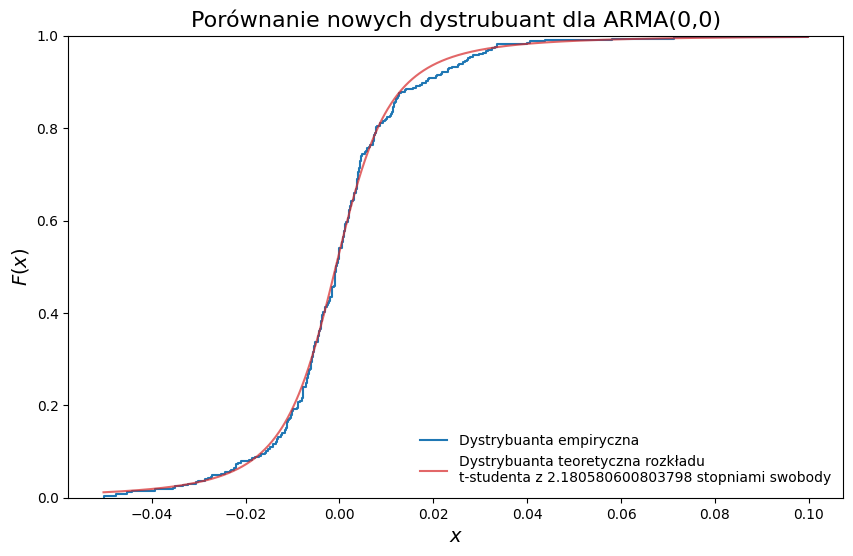

In [167]:
plt.figure(figsize=(10, 6))
sns.ecdfplot(data = residuals_2_2, label = "Dystrybuanta empiryczna")

t = np.linspace(np.min(residuals_2_2), np.max(residuals_2_2), 1000)
params_2_2 = stats.t.fit(residuals_2_2)
th_F = stats.t.cdf(t,  params_2_2[0],params_2_2[1], params_2_2[2])
plt.plot(t, th_F, label = f"Dystrybuanta teoretyczna rozkładu\nt-studenta z {params_2_2[0]} stopniami swobody", alpha = 0.7, color = "C3")

plt.title("Porównanie nowych dystrubuant dla ARMA(0,0)", fontsize=16)
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$F(x)$", fontsize=14)
plt.legend(frameon=False)
plt.show()